# **Installing dependencies **


---



In [2]:
!pip install together python-docx PyPDF2 pytesseract streamlit pandas matplotlib seaborn pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
  Attempting uninstall: typer
    Found existing installation: typer 0.16.0
    Uninstalling typer-0.16.0:
      Successfully uninstalled typer-0

In [5]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,776 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,986 kB]
Get:13 https://ppa.launchpadcontent.net/de

# APi key


---



In [16]:
# please use your own api key over here
TOGETHER_API_KEY = "use-your-api-key"
MODEL = "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"

# Code


---



In [24]:
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from PIL import Image
import re
import base64
from IPython.display import display, HTML, Image as IPImage
import time
import warnings
warnings.filterwarnings('ignore')
from docx import Document
import PyPDF2
import pytesseract
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

class DataAnalystAgent:
    """
    An intelligent data analyst agent that can process various file formats,
    perform comprehensive analysis, and answer questions about the data.
    """

    def __init__(self, api_key=None):
        self.api_key = api_key or TOGETHER_API_KEY
        self.model = MODEL
        self.conversation_history = []
        self.current_data = None
        self.current_analysis = None

    def query_together_ai(self, prompt, max_tokens=1024, temperature=0.7, retry_count=3, base_delay=5):
        """Query the Together.ai API with enhanced error handling and rate limiting."""
        url = "https://api.together.xyz/v1/completions"
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }
        data = {
            "model": self.model,
            "prompt": prompt,
            "max_tokens": max_tokens,
            "temperature": temperature
        }

        for attempt in range(retry_count):
            try:
                response = requests.post(url, headers=headers, json=data, timeout=30)

                if response.status_code == 200:
                    result = response.json()
                    if 'choices' in result and len(result['choices']) > 0:
                        return result["choices"][0]["text"].strip()
                    else:
                        return "Error: No response generated from the model."

                elif response.status_code == 429:  # Rate limit error
                    if attempt < retry_count - 1:
                        delay = base_delay * (2 ** attempt)
                        print(f"Rate limit hit. Retrying in {delay} seconds...")
                        time.sleep(delay)
                    else:
                        return "Rate limit exceeded. Please wait before making another request."

                elif response.status_code == 401:
                    return "Authentication error. Please check your API key."

                else:
                    return f"API Error: {response.status_code} - {response.text}"

            except requests.exceptions.Timeout:
                return "Request timeout. Please try again."
            except requests.exceptions.ConnectionError:
                return "Connection error. Please check your internet connection."
            except Exception as e:
                if attempt < retry_count - 1:
                    print(f"Exception occurred: {e}. Retrying...")
                    time.sleep(2 ** attempt)
                else:
                    return f"Error after {retry_count} attempts: {str(e)}"

        return "Maximum retry attempts reached. Please try again later."

    # File Processing Methods
    def process_text_file(self, file_content):
        """Process a text file and extract its content."""
        try:
            if isinstance(file_content, bytes):
                content = file_content.decode('utf-8', errors='ignore')
            else:
                content = str(file_content)
            return {"text": content, "type": "text", "status": "success"}
        except Exception as e:
            return {"error": f"Error processing text file: {str(e)}", "status": "error"}

    def process_docx_file(self, file_content):
        """Process a Word document and extract its content."""
        try:
            doc = Document(io.BytesIO(file_content))
            text = "\n".join([para.text for para in doc.paragraphs if para.text.strip()])
            return {"text": text, "type": "text", "status": "success"}
        except Exception as e:
            return {"error": f"Error processing DOCX file: {str(e)}", "status": "error"}

    def process_pdf_file(self, file_content):
        """Process a PDF file and extract its content."""
        try:
            pdf_reader = PyPDF2.PdfReader(io.BytesIO(file_content))
            text = ""
            for page_num in range(len(pdf_reader.pages)):
                page_text = pdf_reader.pages[page_num].extract_text()
                if page_text:
                    text += page_text + "\n"

            if not text.strip():
                return {"error": "Could not extract text from PDF. The PDF might be image-based.", "status": "error"}

            return {"text": text, "type": "text", "status": "success"}
        except Exception as e:
            return {"error": f"Error processing PDF: {str(e)}", "status": "error"}

    def process_image_file(self, file_content):
        """Process an image file and extract any text using OCR."""
        try:
            img = Image.open(io.BytesIO(file_content))

            # Enhance image for better OCR
            img = img.convert('RGB')

            # Extract text using OCR
            text = pytesseract.image_to_string(img)

            return {
                "text": text,
                "type": "text",
                "image": img,
                "status": "success",
                "ocr_confidence": "OCR extracted text"
            }
        except Exception as e:
            return {"error": f"Error processing image: {str(e)}", "status": "error"}

    def process_csv_file(self, file_content):
        """Process a CSV file and load it as a pandas DataFrame."""
        try:
            # Try different encodings and separators
            encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
            separators = [',', ';', '\t', '|']

            for encoding in encodings:
                for sep in separators:
                    try:
                        df = pd.read_csv(io.BytesIO(file_content), encoding=encoding, sep=sep)
                        if len(df.columns) > 1 and len(df) > 0:  # Valid DataFrame
                            return {"dataframe": df, "type": "tabular", "status": "success"}
                    except:
                        continue

            # If all attempts fail, try with default settings
            df = pd.read_csv(io.BytesIO(file_content))
            return {"dataframe": df, "type": "tabular", "status": "success"}

        except Exception as e:
            return {"error": f"Error processing CSV: {str(e)}", "status": "error"}

    def process_excel_file(self, file_content):
        """Process an Excel file and load it as a pandas DataFrame."""
        try:
            # Try to read the first sheet
            df = pd.read_excel(io.BytesIO(file_content), sheet_name=0)

            # If the first sheet is empty, try other sheets
            if df.empty:
                excel_file = pd.ExcelFile(io.BytesIO(file_content))
                for sheet_name in excel_file.sheet_names:
                    df = pd.read_excel(io.BytesIO(file_content), sheet_name=sheet_name)
                    if not df.empty:
                        break

            return {"dataframe": df, "type": "tabular", "status": "success"}
        except Exception as e:
            return {"error": f"Error processing Excel file: {str(e)}", "status": "error"}

    def process_file(self, file_path, file_content):
        """Process a file based on its extension and return appropriate data structure."""
        file_extension = file_path.split('.')[-1].lower()

        processors = {
            'txt': self.process_text_file,
            'docx': self.process_docx_file,
            'doc': self.process_docx_file,
            'pdf': self.process_pdf_file,
            'jpg': self.process_image_file,
            'jpeg': self.process_image_file,
            'png': self.process_image_file,
            'csv': self.process_csv_file,
            'xlsx': self.process_excel_file,
            'xls': self.process_excel_file
        }

        if file_extension in processors:
            result = processors[file_extension](file_content)
            if result.get("status") == "success":
                print(f"✅ Successfully processed {file_path}")
            else:
                print(f"❌ Error processing {file_path}: {result.get('error', 'Unknown error')}")
            return result
        else:
            return {"error": f"Unsupported file format: {file_extension}", "status": "error"}

    # Enhanced Data Analysis Methods
    def analyze_tabular_data(self, data):
        """Enhanced tabular data analysis with more insights."""
        df = data["dataframe"]

        analysis = {
            "basic_info": {
                "shape": df.shape,
                "columns": list(df.columns),
                "dtypes": df.dtypes.apply(str).to_dict(),
                "memory_usage": df.memory_usage(deep=True).sum()
            },
            "missing_data": {
                "missing_counts": df.isnull().sum().to_dict(),
                "missing_percentages": (df.isnull().sum() / len(df) * 100).to_dict(),
                "complete_rows": len(df.dropna())
            },
            "statistics": {},
            "categorical_analysis": {},
            "correlations": {},
            "outliers": {},
            "data_quality": {}
        }

        # Numerical analysis
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            analysis["statistics"] = df[numeric_cols].describe().to_dict()

            # Correlation analysis
            if len(numeric_cols) > 1:
                corr_matrix = df[numeric_cols].corr()
                analysis["correlations"] = corr_matrix.to_dict()

                # Find strong correlations
                strong_corrs = []
                for i in range(len(corr_matrix.columns)):
                    for j in range(i+1, len(corr_matrix.columns)):
                        col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                        corr_val = corr_matrix.iloc[i, j]
                        if abs(corr_val) > 0.7:
                            strong_corrs.append((col1, col2, corr_val))
                analysis["strong_correlations"] = strong_corrs

            # Outlier detection using IQR method
            for col in numeric_cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
                analysis["outliers"][col] = {
                    "count": len(outliers),
                    "percentage": (len(outliers) / len(df)) * 100,
                    "bounds": [lower_bound, upper_bound]
                }

        # Categorical analysis
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            value_counts = df[col].value_counts()
            analysis["categorical_analysis"][col] = {
                "unique_count": df[col].nunique(),
                "most_frequent": value_counts.index[0] if len(value_counts) > 0 else None,
                "most_frequent_count": value_counts.iloc[0] if len(value_counts) > 0 else 0,
                "distribution": value_counts.head(10).to_dict()
            }

        # Data quality assessment
        analysis["data_quality"] = {
            "duplicate_rows": df.duplicated().sum(),
            "duplicate_percentage": (df.duplicated().sum() / len(df)) * 100,
            "columns_with_nulls": df.isnull().any().sum(),
            "data_completeness": ((df.size - df.isnull().sum().sum()) / df.size) * 100
        }

        return analysis

    def analyze_text_data(self, data):
        """Enhanced text analysis with more linguistic insights."""
        text = data["text"]

        # Basic text statistics
        char_count = len(text)
        words = re.findall(r'\b\w+\b', text.lower())
        word_count = len(words)
        unique_word_count = len(set(words))
        sentences = re.split(r'[.!?]+', text)
        sentence_count = len([s for s in sentences if s.strip()])
        paragraphs = text.split('\n\n')
        paragraph_count = len([p for p in paragraphs if p.strip()])

        # Word frequency analysis
        word_freq = {}
        for word in words:
            if len(word) > 2:  # Skip very short words
                word_freq[word] = word_freq.get(word, 0) + 1

        # Sort by frequency
        word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:30])

        # Reading complexity metrics
        avg_word_length = sum(len(word) for word in words) / len(words) if words else 0
        avg_sentence_length = sum(len(sentence.split()) for sentence in sentences if sentence.strip()) / sentence_count if sentence_count > 0 else 0

        # Lexical diversity (unique words / total words)
        lexical_diversity = unique_word_count / word_count if word_count > 0 else 0

        analysis = {
            "basic_stats": {
                "character_count": char_count,
                "word_count": word_count,
                "unique_word_count": unique_word_count,
                "sentence_count": sentence_count,
                "paragraph_count": paragraph_count,
                "lexical_diversity": lexical_diversity
            },
            "complexity_metrics": {
                "avg_word_length": avg_word_length,
                "avg_sentence_length": avg_sentence_length,
                "reading_ease": self.calculate_reading_ease(word_count, sentence_count, avg_word_length)
            },
            "word_frequency": word_freq,
            "content_preview": text[:500] + "..." if len(text) > 500 else text
        }

        return analysis

    def calculate_reading_ease(self, word_count, sentence_count, avg_word_length):
        """Calculate a simple reading ease score."""
        if sentence_count == 0 or word_count == 0:
            return 0

        # Simplified Flesch Reading Ease approximation
        asl = word_count / sentence_count  # Average sentence length
        asw = avg_word_length  # Average syllables per word (approximated by character length)

        # Simplified formula
        reading_ease = 206.835 - (1.015 * asl) - (84.6 * (asw / 5))
        return max(0, min(100, reading_ease))

    # Enhanced Visualization Methods
    def generate_visualizations(self, data):
        """Generate comprehensive visualizations based on data type."""
        visualizations = []

        if data["type"] == "tabular":
            df = data["dataframe"]

            # Set style for better-looking plots
            plt.style.use('seaborn-v0_8')
            sns.set_palette("husl")

            # Numerical columns analysis
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

            for col in numeric_cols[:4]:  # Limit to first 4 numeric columns
                fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                fig.suptitle(f'Analysis of {col}', fontsize=16, fontweight='bold')

                # Histogram with KDE
                axes[0, 0].hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
                axes[0, 0].set_title('Distribution')
                axes[0, 0].set_xlabel(col)
                axes[0, 0].set_ylabel('Frequency')

                # Box plot
                axes[0, 1].boxplot(df[col].dropna())
                axes[0, 1].set_title('Box Plot (Outlier Detection)')
                axes[0, 1].set_ylabel(col)

                # Q-Q plot for normality check
                from scipy import stats
                stats.probplot(df[col].dropna(), dist="norm", plot=axes[1, 0])
                axes[1, 0].set_title('Q-Q Plot (Normality Check)')

                # Time series if index is datetime-like
                if len(df) > 1:
                    axes[1, 1].plot(df.index, df[col], alpha=0.7)
                    axes[1, 1].set_title('Values over Index')
                    axes[1, 1].set_xlabel('Index')
                    axes[1, 1].set_ylabel(col)

                plt.tight_layout()

                # Convert to base64
                buf = io.BytesIO()
                plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
                buf.seek(0)
                img_str = base64.b64encode(buf.read()).decode('utf-8')

                visualizations.append({
                    "title": f"Comprehensive Analysis of {col}",
                    "type": "numerical_analysis",
                    "image_data": img_str
                })
                plt.close()

            # Categorical columns analysis
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

            for col in categorical_cols[:3]:  # Limit to first 3 categorical columns
                if df[col].nunique() <= 15:  # Only plot if reasonable number of categories
                    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
                    fig.suptitle(f'Analysis of {col}', fontsize=16, fontweight='bold')

                    # Value counts bar plot
                    value_counts = df[col].value_counts().head(10)
                    axes[0].bar(range(len(value_counts)), value_counts.values)
                    axes[0].set_xticks(range(len(value_counts)))
                    axes[0].set_xticklabels(value_counts.index, rotation=45, ha='right')
                    axes[0].set_title('Frequency Distribution')
                    axes[0].set_ylabel('Count')

                    # Pie chart
                    if len(value_counts) <= 8:  # Only pie chart for reasonable number of categories
                        axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
                        axes[1].set_title('Proportion Distribution')
                    else:
                        axes[1].barh(range(len(value_counts)), value_counts.values)
                        axes[1].set_yticks(range(len(value_counts)))
                        axes[1].set_yticklabels(value_counts.index)
                        axes[1].set_title('Horizontal Bar Chart')

                    plt.tight_layout()

                    # Convert to base64
                    buf = io.BytesIO()
                    plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
                    buf.seek(0)
                    img_str = base64.b64encode(buf.read()).decode('utf-8')

                    visualizations.append({
                        "title": f"Distribution Analysis of {col}",
                        "type": "categorical_analysis",
                        "image_data": img_str
                    })
                    plt.close()

            # Correlation heatmap for numerical columns
            if len(numeric_cols) > 1:
                plt.figure(figsize=(12, 10))
                corr_matrix = df[numeric_cols].corr()

                # Create mask for upper triangle
                mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

                sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm',
                           center=0, square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
                plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
                plt.tight_layout()

                # Convert to base64
                buf = io.BytesIO()
                plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
                buf.seek(0)
                img_str = base64.b64encode(buf.read()).decode('utf-8')

                visualizations.append({
                    "title": "Correlation Matrix",
                    "type": "correlation_analysis",
                    "image_data": img_str
                })
                plt.close()

            # Pairplot for key numerical columns (max 4)
            if len(numeric_cols) >= 2:
                sample_cols = numeric_cols[:4]
                if len(df) > 1000:  # Sample for large datasets
                    sample_df = df[sample_cols].sample(1000)
                else:
                    sample_df = df[sample_cols]

                g = sns.pairplot(sample_df, diag_kind='hist')
                g.fig.suptitle('Pairwise Relationships', y=1.02, fontsize=16, fontweight='bold')

                # Convert to base64
                buf = io.BytesIO()
                plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
                buf.seek(0)
                img_str = base64.b64encode(buf.read()).decode('utf-8')

                visualizations.append({
                    "title": "Pairwise Relationships",
                    "type": "pairplot",
                    "image_data": img_str
                })
                plt.close()

        elif data["type"] == "text":
            analysis = self.analyze_text_data(data)

            # Word frequency visualization
            if analysis["word_frequency"]:
                fig, axes = plt.subplots(2, 1, figsize=(15, 12))

                # Top words bar chart
                words = list(analysis["word_frequency"].keys())[:20]
                counts = list(analysis["word_frequency"].values())[:20]

                axes[0].barh(range(len(words)), counts)
                axes[0].set_yticks(range(len(words)))
                axes[0].set_yticklabels(words)
                axes[0].set_title('Top 20 Most Frequent Words', fontsize=14, fontweight='bold')
                axes[0].set_xlabel('Frequency')

                # Word cloud effect with scatter plot
                x_pos = np.random.random(len(words[:15])) * 10
                y_pos = np.random.random(len(words[:15])) * 10
                sizes = [count * 100 for count in counts[:15]]

                scatter = axes[1].scatter(x_pos, y_pos, s=sizes, alpha=0.6, c=counts[:15], cmap='viridis')

                for i, word in enumerate(words[:15]):
                    axes[1].annotate(word, (x_pos[i], y_pos[i]), ha='center', va='center')

                axes[1].set_title('Word Frequency Visualization', fontsize=14, fontweight='bold')
                axes[1].set_xlim(0, 10)
                axes[1].set_ylim(0, 10)
                axes[1].axis('off')

                plt.tight_layout()

                # Convert to base64
                buf = io.BytesIO()
                plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
                buf.seek(0)
                img_str = base64.b64encode(buf.read()).decode('utf-8')

                visualizations.append({
                    "title": "Text Analysis Visualization",
                    "type": "text_analysis",
                    "image_data": img_str
                })
                plt.close()

        return visualizations

    def display_visualizations(self, visualizations):
        """Display visualizations in the notebook."""
        for viz in visualizations:
            display(HTML(f"<h3 style='color: #2E86AB; border-bottom: 2px solid #2E86AB;'>{viz.get('title', 'Visualization')}</h3>"))
            display(HTML(f'<img src="data:image/png;base64,{viz["image_data"]}" style="max-width: 100%; height: auto; border: 1px solid #ddd; border-radius: 8px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);" />'))
            display(HTML("<br>"))

    # Enhanced AI Agent Methods
    def format_analysis_for_llm(self, data, analysis):
        """Create a comprehensive prompt for the AI model."""
        if data["type"] == "tabular":
            df = data["dataframe"]

            prompt_parts = [
                "You are an expert data scientist and analyst. Analyze the following dataset information and provide insights:",
                f"\n🔍 DATASET OVERVIEW:",
                f"• Shape: {df.shape[0]:,} rows × {df.shape[1]} columns",
                f"• Data completeness: {analysis['data_quality']['data_completeness']:.1f}%",
                f"• Duplicate rows: {analysis['data_quality']['duplicate_rows']:,} ({analysis['data_quality']['duplicate_percentage']:.1f}%)",

                f"\n📊 COLUMN INFORMATION:"
            ]

            # Column details
            for col, dtype in analysis["basic_info"]["dtypes"].items():
                missing_pct = analysis["missing_data"]["missing_percentages"].get(col, 0)
                prompt_parts.append(f"• {col} ({dtype}): {missing_pct:.1f}% missing")

            # Statistical insights for numerical columns
            if analysis["statistics"]:
                prompt_parts.append(f"\n📈 NUMERICAL ANALYSIS:")
                for col, stats in analysis["statistics"].items():
                    if isinstance(stats, dict):
                        mean_val = stats.get('mean', 0)
                        std_val = stats.get('std', 0)
                        min_val = stats.get('min', 0)
                        max_val = stats.get('max', 0)
                        prompt_parts.append(f"• {col}: Mean={mean_val:.2f}, Std={std_val:.2f}, Range=[{min_val:.2f}, {max_val:.2f}]")

            # Categorical insights
            if analysis["categorical_analysis"]:
                prompt_parts.append(f"\n🏷️ CATEGORICAL ANALYSIS:")
                for col, cat_info in analysis["categorical_analysis"].items():
                    unique_count = cat_info["unique_count"]
                    most_freq = cat_info["most_frequent"]
                    prompt_parts.append(f"• {col}: {unique_count} unique values, most frequent: '{most_freq}'")

            # Correlation insights
            if analysis.get("strong_correlations"):
                prompt_parts.append(f"\n🔗 STRONG CORRELATIONS:")
                for col1, col2, corr_val in analysis["strong_correlations"]:
                    prompt_parts.append(f"• {col1} ↔ {col2}: {corr_val:.3f}")

            # Outlier information
            if analysis["outliers"]:
                prompt_parts.append(f"\n⚠️ OUTLIER DETECTION:")
                for col, outlier_info in analysis["outliers"].items():
                    if outlier_info["count"] > 0:
                        prompt_parts.append(f"• {col}: {outlier_info['count']} outliers ({outlier_info['percentage']:.1f}%)")

            return "\n".join(prompt_parts)

        elif data["type"] == "text":
            prompt_parts = [
                "You are an expert text analyst and linguist. Analyze the following text document:",
                f"\n📄 TEXT OVERVIEW:",
                f"• Characters: {analysis['basic_stats']['character_count']:,}",
                f"• Words: {analysis['basic_stats']['word_count']:,}",
                f"• Unique words: {analysis['basic_stats']['unique_word_count']:,}",
                f"• Sentences: {analysis['basic_stats']['sentence_count']:,}",
                f"• Paragraphs: {analysis['basic_stats']['paragraph_count']:,}",
                f"• Lexical diversity: {analysis['basic_stats']['lexical_diversity']:.3f}",

                f"\n📊 COMPLEXITY METRICS:",
                f"• Average word length: {analysis['complexity_metrics']['avg_word_length']:.1f} characters",
                f"• Average sentence length: {analysis['complexity_metrics']['avg_sentence_length']:.1f} words",
                f"• Reading ease score: {analysis['complexity_metrics']['reading_ease']:.1f}/100",

                f"\n🔤 TOP FREQUENT WORDS:",
                ", ".join([f"{word}({count})" for word, count in list(analysis['word_frequency'].items())[:15]]),

                f"\n📝 CONTENT PREVIEW:",
                analysis['content_preview']
            ]

            return "\n".join(prompt_parts)

        return "No analysis available for this data type."




    def ask_agent(self, question, context=None):
        """Query the AI agent with enhanced context and better prompting."""
        if not self.current_data or not self.current_analysis:
            return "❌ No data available. Please upload and process a file first."

        # Build comprehensive context
        data_context = self.format_analysis_for_llm(self.current_data, self.current_analysis)

        # Include conversation history
        conversation_context = ""
        if self.conversation_history:
            conversation_context = "\n\nPREVIOUS CONVERSATION:\n" + "\n".join([
                f"User: {q}\nAssistant: {a}" for q, a in self.conversation_history[-3:]  # Include last 3 exchanges
            ])

        # Check if we can directly answer without using the API
        direct_answer = self.get_direct_answer(question)
        if direct_answer:
            self.conversation_history.append((question, direct_answer))
            return direct_answer

        # Build the full prompt
        prompt = f"""You are an advanced data analysis assistant with expertise in analyzing various types of data. You provide clear, insightful, and accurate analyses based on the data provided.

    DATA INFORMATION:
    {data_context}

    {conversation_context}

    USER QUESTION:
    {question}

    Please provide a step-by-step analysis that directly answers the user's question. Use specific numbers and facts from the data. When appropriate, suggest visualizations that could help illustrate your answer.

    Structure your answer clearly with sections and bullet points where relevant. If you're not sure or if information is missing, explain what would be needed to provide a complete answer.
    """

        # Get response from API
        response = self.query_together_ai(prompt, max_tokens=1800, temperature=0.3)

        # Update conversation history
        self.conversation_history.append((question, response))

        return response

    def get_direct_answer(self, question):
        """Provide direct answers for common questions to avoid API calls."""
        question_lower = question.lower()

        # Only try direct answers if we have tabular data
        if self.current_data["type"] != "tabular":
            return None

        df = self.current_data["dataframe"]

        # Check for highest/lowest value questions
        if any(x in question_lower for x in ["highest", "maximum", "largest", "greatest"]):
            for col in df.columns:
                if col.lower() in question_lower and pd.api.types.is_numeric_dtype(df[col]):
                    try:
                        # Find highest value and corresponding row
                        max_val = df[col].max()
                        max_idx = df[col].idxmax()
                        max_row = df.loc[max_idx]

                        result = f"The highest value in '{col}' is {max_val}."
                        if len(df.columns) <= 6:  # Only add row details if not too many columns
                            result += f"\nThis occurs in row {max_idx} with values:\n"
                            for c, v in max_row.items():
                                result += f"- {c}: {v}\n"
                        return result
                    except:
                        pass

        if any(x in question_lower for x in ["lowest", "minimum", "smallest", "least"]):
            for col in df.columns:
                if col.lower() in question_lower and pd.api.types.is_numeric_dtype(df[col]):
                    try:
                        # Find lowest value and corresponding row
                        min_val = df[col].min()
                        min_idx = df[col].idxmin()
                        min_row = df.loc[min_idx]

                        result = f"The lowest value in '{col}' is {min_val}."
                        if len(df.columns) <= 6:  # Only add row details if not too many columns
                            result += f"\nThis occurs in row {min_idx} with values:\n"
                            for c, v in min_row.items():
                                result += f"- {c}: {v}\n"
                        return result
                    except:
                        pass

        # Check for average/mean questions
        if any(x in question_lower for x in ["average", "mean", "median"]):
            for col in df.columns:
                if col.lower() in question_lower and pd.api.types.is_numeric_dtype(df[col]):
                    try:
                        mean_val = df[col].mean()
                        median_val = df[col].median()

                        return f"For '{col}':\n- Mean (average): {mean_val:.4f}\n- Median: {median_val:.4f}"
                    except:
                        pass

        # Check for count/frequency questions for categorical columns
        if any(x in question_lower for x in ["how many", "count", "frequency", "distribution"]):
            for col in df.columns:
                if col.lower() in question_lower and not pd.api.types.is_numeric_dtype(df[col]):
                    try:
                        value_counts = df[col].value_counts()
                        result = f"Distribution of values in '{col}':\n"
                        for val, count in value_counts.head(10).items():
                            result += f"- {val}: {count} ({count/len(df)*100:.1f}%)\n"

                        if len(value_counts) > 10:
                            result += f"(showing top 10 of {len(value_counts)} unique values)"

                        return result
                    except:
                        pass

        # No direct answer possible
        return None

    def generate_visualization_for_question(self, question):
        """Generate a specific visualization based on the user's question."""
        if not self.current_data or self.current_data["type"] != "tabular":
            return None

        df = self.current_data["dataframe"]
        question_lower = question.lower()

        try:
            # Extract column names mentioned in the question
            mentioned_cols = []
            for col in df.columns:
                if col.lower() in question_lower:
                    mentioned_cols.append(col)

            # Handle day of week questions specifically
            if any(phrase in question_lower for phrase in ["day of the week", "day of week", "weekday"]):
                if "purchasedate" in [col.lower() for col in df.columns]:
                    date_col = next(col for col in df.columns if col.lower() == "purchasedate")
                    amount_col = next((col for col in df.columns if "amount" in col.lower()), None)

                    if amount_col:
                        # Ensure date column is datetime
                        if not pd.api.types.is_datetime64_dtype(df[date_col]):
                            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

                        # Extract day of week
                        day_of_week = df[date_col].dt.day_name()

                        # Group by day of week and calculate mean amount
                        weekday_avg = df.groupby(day_of_week)[amount_col].mean().reindex([
                            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
                        ])

                        # Create the plot
                        plt.figure(figsize=(12, 6))
                        ax = weekday_avg.plot(kind='bar', color='skyblue')

                        # Add data labels on top of bars
                        for i, v in enumerate(weekday_avg):
                            ax.text(i, v + 1, f'${v:.2f}', ha='center')

                        plt.title(f'Average {amount_col} by Day of Week')
                        plt.xlabel('Day of Week')
                        plt.ylabel(f'Average {amount_col}')
                        plt.grid(axis='y', alpha=0.3)

                        # Find the day with highest average
                        highest_day = weekday_avg.idxmax()
                        highest_amount = weekday_avg.max()

                        plt.annotate(f'Highest: {highest_day}\n${highest_amount:.2f}',
                                    xy=(weekday_avg.index.get_loc(highest_day), highest_amount),
                                    xytext=(weekday_avg.index.get_loc(highest_day), highest_amount + weekday_avg.max()*0.15),
                                    arrowprops=dict(facecolor='red', shrink=0.05),
                                    horizontalalignment='center')

                        plt.tight_layout()

                        # Save the image to a file and return the answer as text
                        plt.savefig('day_of_week.png')
                        plt.close()

                        return f"The day of the week with the highest average purchase amount is {highest_day} with ${highest_amount:.2f}."

            # Handle relationship/correlation questions
            if any(x in question_lower for x in ["relationship", "correlation", "compare", "versus", "vs"]):
                if len(mentioned_cols) >= 2:
                    col1, col2 = mentioned_cols[:2]

                    # Different plot types based on column types
                    if pd.api.types.is_numeric_dtype(df[col1]) and pd.api.types.is_numeric_dtype(df[col2]):
                        # Scatter plot for two numeric columns
                        plt.figure(figsize=(10, 6))
                        sns.scatterplot(data=df, x=col1, y=col2)
                        plt.title(f'Relationship between {col1} and {col2}')

                        # Add regression line
                        sns.regplot(data=df, x=col1, y=col2, scatter=False, color='red')

                        # Add correlation coefficient
                        corr = df[[col1, col2]].corr().iloc[0, 1]
                        plt.annotate(f'Correlation: {corr:.2f}',
                                    xy=(0.05, 0.95), xycoords='axes fraction')

                    elif pd.api.types.is_numeric_dtype(df[col1]) and not pd.api.types.is_numeric_dtype(df[col2]):
                        # Box plot for numeric vs categorical
                        plt.figure(figsize=(12, 6))
                        sns.boxplot(data=df, x=col2, y=col1)
                        plt.title(f'Distribution of {col1} by {col2}')
                        plt.xticks(rotation=45)

                    elif not pd.api.types.is_numeric_dtype(df[col1]) and pd.api.types.is_numeric_dtype(df[col2]):
                        # Box plot for categorical vs numeric
                        plt.figure(figsize=(12, 6))
                        sns.boxplot(data=df, x=col1, y=col2)
                        plt.title(f'Distribution of {col2} by {col1}')
                        plt.xticks(rotation=45)

                    else:
                        # Heatmap for two categorical columns
                        plt.figure(figsize=(12, 8))
                        crosstab = pd.crosstab(df[col1], df[col2])
                        sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
                        plt.title(f'Relationship between {col1} and {col2}')
                        plt.xticks(rotation=45)
                        plt.yticks(rotation=0)

                    # Save the chart
                    plt.tight_layout()
                    plt.savefig('relationship.png')
                    plt.close()
                    return f"Generated visualization showing the relationship between {col1} and {col2}."

            # Handle distribution questions
            elif any(x in question_lower for x in ["distribution", "histogram", "spread"]):
                if mentioned_cols:
                    col = mentioned_cols[0]

                    if pd.api.types.is_numeric_dtype(df[col]):
                        # Create histogram
                        plt.figure(figsize=(12, 6))
                        sns.histplot(data=df, x=col, kde=True)
                        plt.title(f'Distribution of {col}')

                        # Add summary statistics
                        mean_val = df[col].mean()
                        median_val = df[col].median()
                        plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
                        plt.axvline(median_val, color='green', linestyle='-.', label=f'Median: {median_val:.2f}')
                        plt.legend()

                    else:
                        # Create bar chart for categorical column
                        plt.figure(figsize=(12, 6))
                        value_counts = df[col].value_counts()
                        if len(value_counts) > 15:  # If too many categories, limit
                            value_counts = value_counts.head(15)
                            title = f'Distribution of {col} (Top 15 categories)'
                        else:
                            title = f'Distribution of {col}'

                        sns.barplot(x=value_counts.index, y=value_counts.values)
                        plt.title(title)
                        plt.xticks(rotation=45, ha='right')

                    # Save the chart
                    plt.tight_layout()
                    plt.savefig('distribution.png')
                    plt.close()
                    return f"Generated distribution visualization for {col}."

            # Handle time trend questions
            elif any(x in question_lower for x in ["trend", "time", "over time", "change"]):
                date_cols = []
                for col in df.columns:
                    if pd.api.types.is_datetime64_dtype(df[col]) or 'date' in col.lower() or 'time' in col.lower():
                        try:
                            df[col] = pd.to_datetime(df[col])
                            date_cols.append(col)
                        except:
                            pass

                if date_cols and len(mentioned_cols) > 0:
                    date_col = date_cols[0]
                    value_col = None

                    # Find the mentioned column that isn't the date column
                    for col in mentioned_cols:
                        if col != date_col and pd.api.types.is_numeric_dtype(df[col]):
                            value_col = col
                            break

                    if value_col:
                        # Sort by date
                        temp_df = df.sort_values(by=date_col)

                        # Create time series plot
                        plt.figure(figsize=(14, 6))
                        plt.plot(temp_df[date_col], temp_df[value_col], marker='o', linestyle='-')
                        plt.title(f'{value_col} over {date_col}')
                        plt.xlabel(date_col)
                        plt.ylabel(value_col)
                        plt.grid(True, alpha=0.3)
                        plt.xticks(rotation=45)

                        # Save the chart
                        plt.tight_layout()
                        plt.savefig('time_trend.png')
                        plt.close()
                        return f"Generated time trend visualization of {value_col} over {date_col}."

        except Exception as e:
            print(f"Error generating visualization: {str(e)}")
            return None

        finally:
            plt.close()

        return None



    def upload_and_process_file(self):
        """Upload and process a file using Google Colab's file upload functionality."""
        from google.colab import files

        print("📤 Please upload a file (.txt, .docx, .pdf, .jpg, .jpeg, .png, .csv, .xlsx)")
        uploaded = files.upload()

        if not uploaded:
            print("❌ No file uploaded.")
            return False

        for filename, file_content in uploaded.items():
            print(f"⏳ Processing {filename}...")
            processed_data = self.process_file(filename, file_content)

            if processed_data.get("status") == "error":
                print(f"❌ Error: {processed_data.get('error', 'Unknown error')}")
                return False

            self.current_data = processed_data

            # Analyze the data
            print("🔍 Analyzing the data...")
            if processed_data["type"] == "tabular":
                self.current_analysis = self.analyze_tabular_data(processed_data)
                print(f"✅ Data analyzed successfully! Shape: {processed_data['dataframe'].shape}")
                display(processed_data["dataframe"].head())
            elif processed_data["type"] == "text":
                self.current_analysis = self.analyze_text_data(processed_data)
                print(f"✅ Text analyzed successfully! Length: {len(processed_data['text'])} characters")
                print(f"Sample: {processed_data['text'][:200]}...")

            # Generate and display visualizations
            print("📊 Generating visualizations...")
            visualizations = self.generate_visualizations(processed_data)
            self.display_visualizations(visualizations)

            return True

        return False

    def interactive_mode(self):
        """Run the agent in interactive mode."""
        print("🤖 Data Analyst Agent - Interactive Mode")
        print("========================================")
        print("1️⃣ Upload and analyze a file")
        print("2️⃣ Use a sample dataset")
        choice = input("Enter your choice (1 or 2): ")

        if choice == "1":
            success = self.upload_and_process_file()
            if not success:
                print("❌ Failed to process file. Please try again.")
                return
        elif choice == "2":
            print("⏳ Creating sample dataset...")
            self.create_sample_dataset()
        else:
            print("❌ Invalid choice. Please restart.")
            return

        # Interactive Q&A session
        print("\n🔍 You can now ask questions about the data!")
        print("Type 'exit', 'quit', or 'bye' to end the session.")

        while True:
            question = input("\n❓ Your question: ")

            if question.lower() in ["exit", "quit", "bye"]:
                break

            if not question.strip():
                continue

            print("⏳ Thinking...")
            response = self.ask_agent(question)

            print("\n🤖 Answer:")
            print(response)

            # Generate visualization if applicable
            viz_buffer = self.generate_visualization_for_question(question)
            if viz_buffer:
                display(IPImage(viz_buffer))

        print("\nThank you for using the Data Analyst Agent! 👋")

    def create_sample_dataset(self):
        """Create a sample dataset for demonstration purposes."""
        print("📊 Creating sample data for demonstration...")

        # Create synthetic dataset
        np.random.seed(42)
        n_samples = 200

        # Generate dates for the past year
        dates = pd.date_range(end=pd.Timestamp.now(), periods=n_samples).tolist()

        # Customer profiles dataset
        customer_ids = range(1, n_samples + 1)
        ages = np.random.normal(45, 15, n_samples).astype(int)
        ages = np.clip(ages, 18, 85)  # Clip to realistic age range

        genders = np.random.choice(['Male', 'Female', 'Non-Binary'], size=n_samples, p=[0.48, 0.48, 0.04])

        regions = np.random.choice(['North', 'South', 'East', 'West', 'Central'],
                                  size=n_samples,
                                  p=[0.2, 0.25, 0.15, 0.3, 0.1])

        # Customer satisfaction correlated with age and region
        base_satisfaction = np.random.normal(7, 1, n_samples)

        # Adjust satisfaction: younger people slightly less satisfied
        age_effect = (ages - 45) * 0.02

        # Regional differences
        region_effect = np.zeros(n_samples)
        for i, region in enumerate(regions):
            if region == 'North':
                region_effect[i] = 0.5
            elif region == 'South':
                region_effect[i] = -0.3
            elif region == 'East':
                region_effect[i] = -0.1
            elif region == 'West':
                region_effect[i] = 0.7

        satisfaction = base_satisfaction + age_effect + region_effect
        satisfaction = np.clip(satisfaction, 1, 10).round(1)  # Scale 1-10

        # Purchase amounts (log-normal distribution)
        purchase_amounts = np.random.lognormal(mean=4.5, sigma=0.7, size=n_samples)
        purchase_amounts = np.round(purchase_amounts, 2)  # Round to 2 decimal places

        # Subscription status with probabilities dependent on satisfaction
        subscription_prob = satisfaction / 10  # Higher satisfaction, higher chance of subscription
        subscription_status = np.random.binomial(1, subscription_prob)
        subscription_types = ['None', 'Basic', 'Premium', 'Gold']

        # Convert to categorical based on subscription status
        subscriptions = []
        for i, status in enumerate(subscription_status):
            if status == 0:
                subscriptions.append('None')
            else:
                sat_score = satisfaction[i]
                if sat_score < 5:
                    subscriptions.append('Basic')
                elif sat_score < 8:
                    subscriptions.append(np.random.choice(['Basic', 'Premium'], p=[0.7, 0.3]))
                else:
                    subscriptions.append(np.random.choice(['Basic', 'Premium', 'Gold'], p=[0.3, 0.5, 0.2]))

        # Create DataFrame
        data = {
            'CustomerID': customer_ids,
            'PurchaseDate': dates,
            'Age': ages,
            'Gender': genders,
            'Region': regions,
            'SatisfactionScore': satisfaction,
            'PurchaseAmount': purchase_amounts,
            'SubscriptionType': subscriptions
        }

        df = pd.DataFrame(data)

        # Add some missing values (5%)
        mask = np.random.random(df.shape) < 0.05
        df = df.mask(mask)

        # Store as current data
        self.current_data = {"dataframe": df, "type": "tabular"}
        print("✅ Sample dataset created!")
        display(df.head())

        # Analyze the data
        print("🔍 Analyzing sample data...")
        self.current_analysis = self.analyze_tabular_data(self.current_data)

        # Generate and display visualizations
        print("📊 Generating visualizations...")
        visualizations = self.generate_visualizations(self.current_data)
        self.display_visualizations(visualizations)

        return df


# **Results**


---



🤖 Initializing Data Analyst Agent...
🤖 Data Analyst Agent - Interactive Mode
1️⃣ Upload and analyze a file
2️⃣ Use a sample dataset
Enter your choice (1 or 2): 2
⏳ Creating sample dataset...
📊 Creating sample data for demonstration...
✅ Sample dataset created!


CustomerID               PurchaseDate   Age  Gender   Region  \
0         1.0 2024-11-26 10:41:19.937480  52.0  Female  Central   
1         2.0 2024-11-27 10:41:19.937480  42.0  Female    South   
2         3.0 2024-11-28 10:41:19.937480  54.0  Female    South   
3         4.0 2024-11-29 10:41:19.937480  67.0  Female     West   
4         5.0 2024-11-30 10:41:19.937480  41.0    Male    South   

   SatisfactionScore  PurchaseAmount SubscriptionType  
0                NaN           30.28              NaN  
1                6.2          137.58            Basic  
2                6.3           36.73          Premium  
3                7.3          307.46             None  
4                6.7           20.96            Basic

🔍 Analyzing sample data...
📊 Generating visualizations...



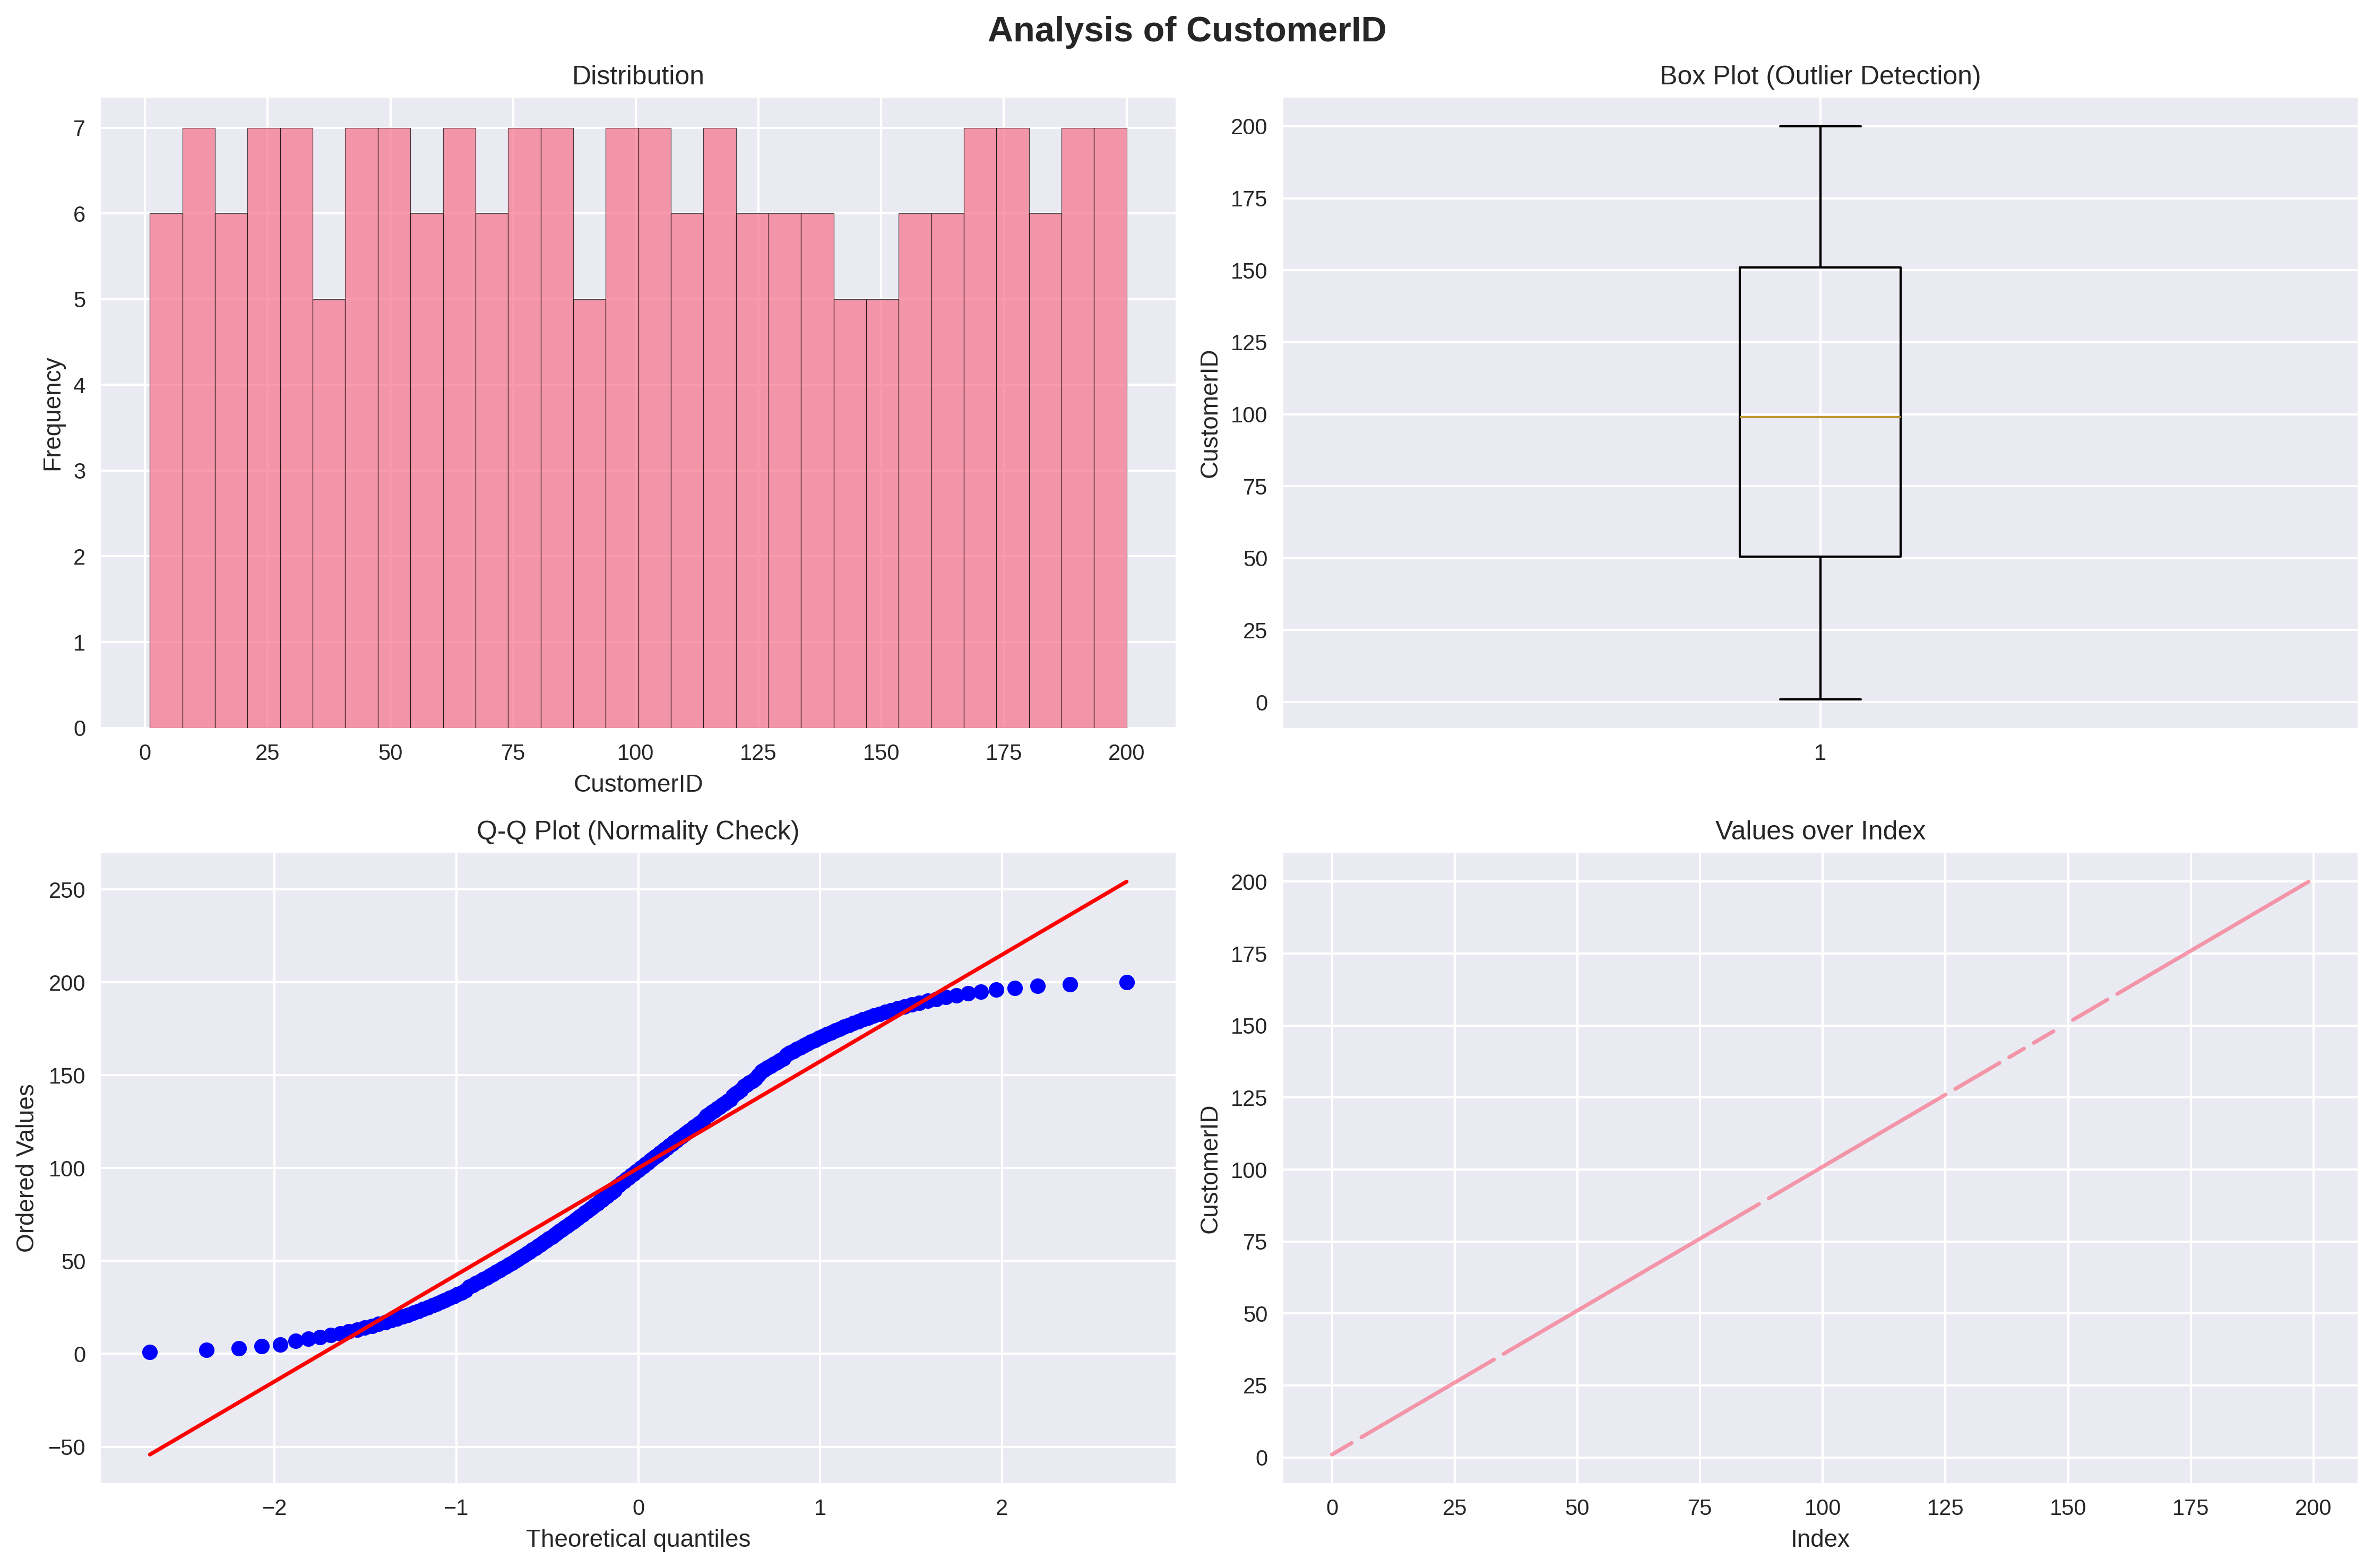


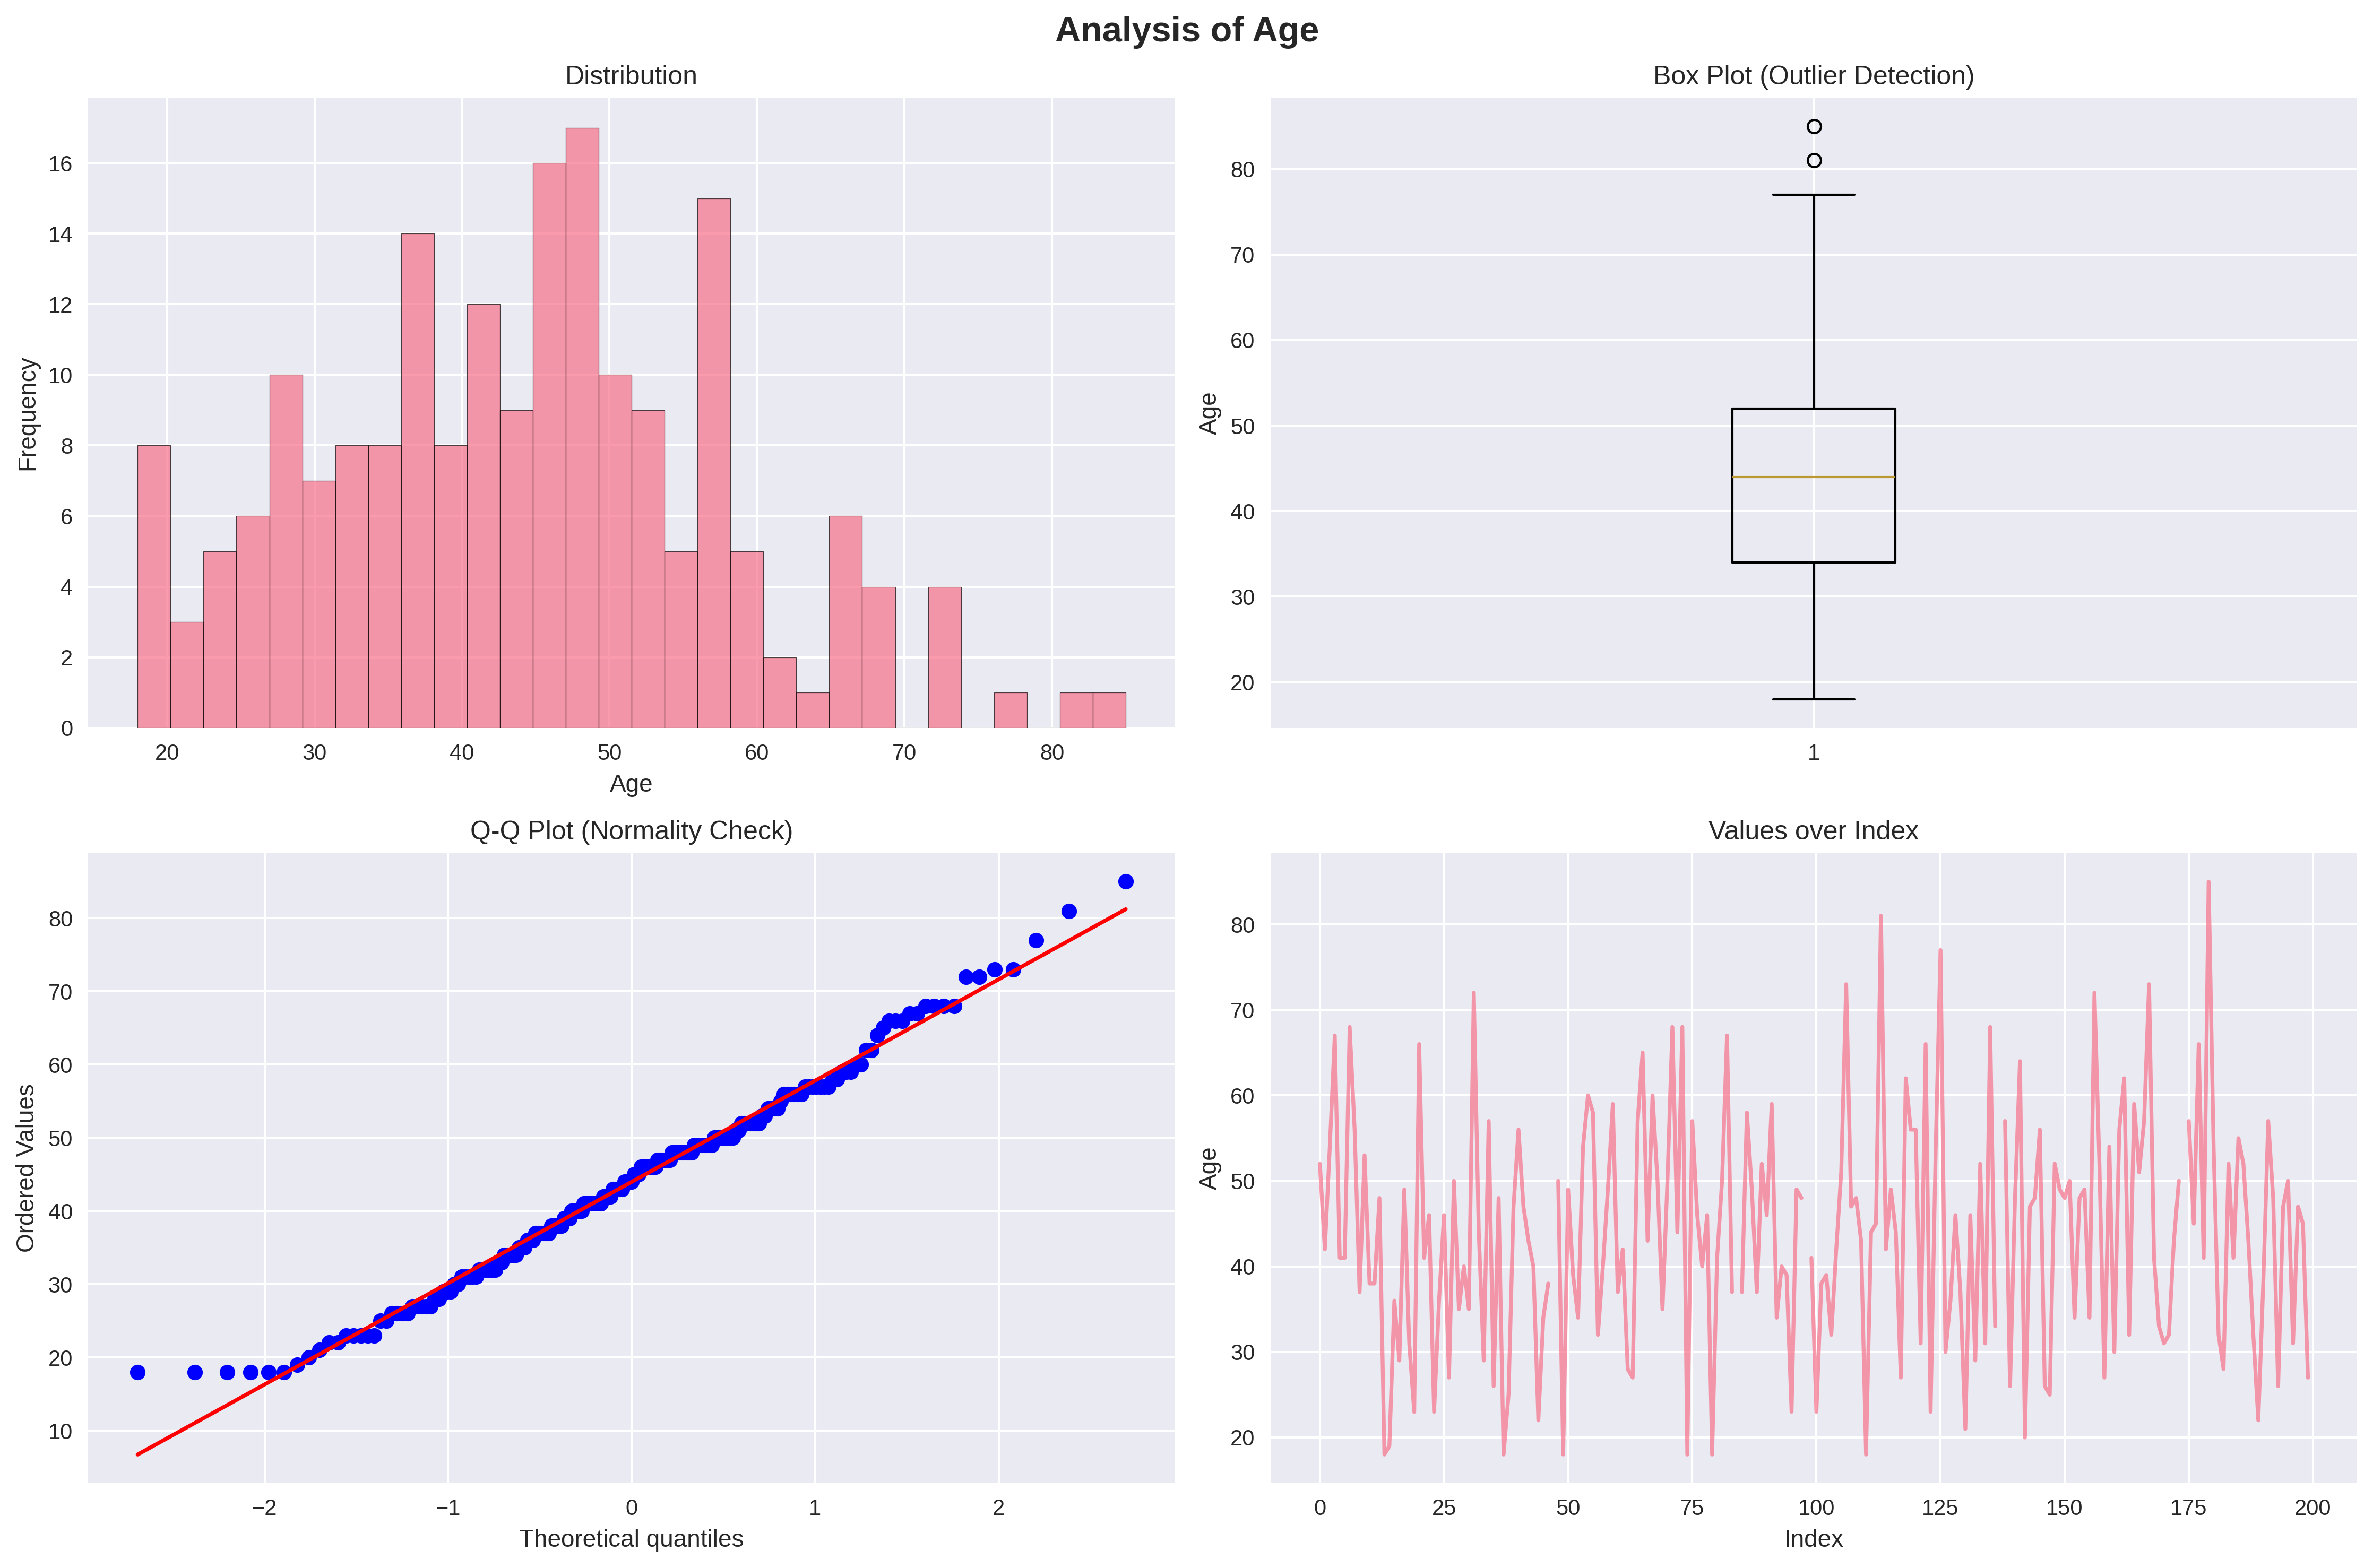


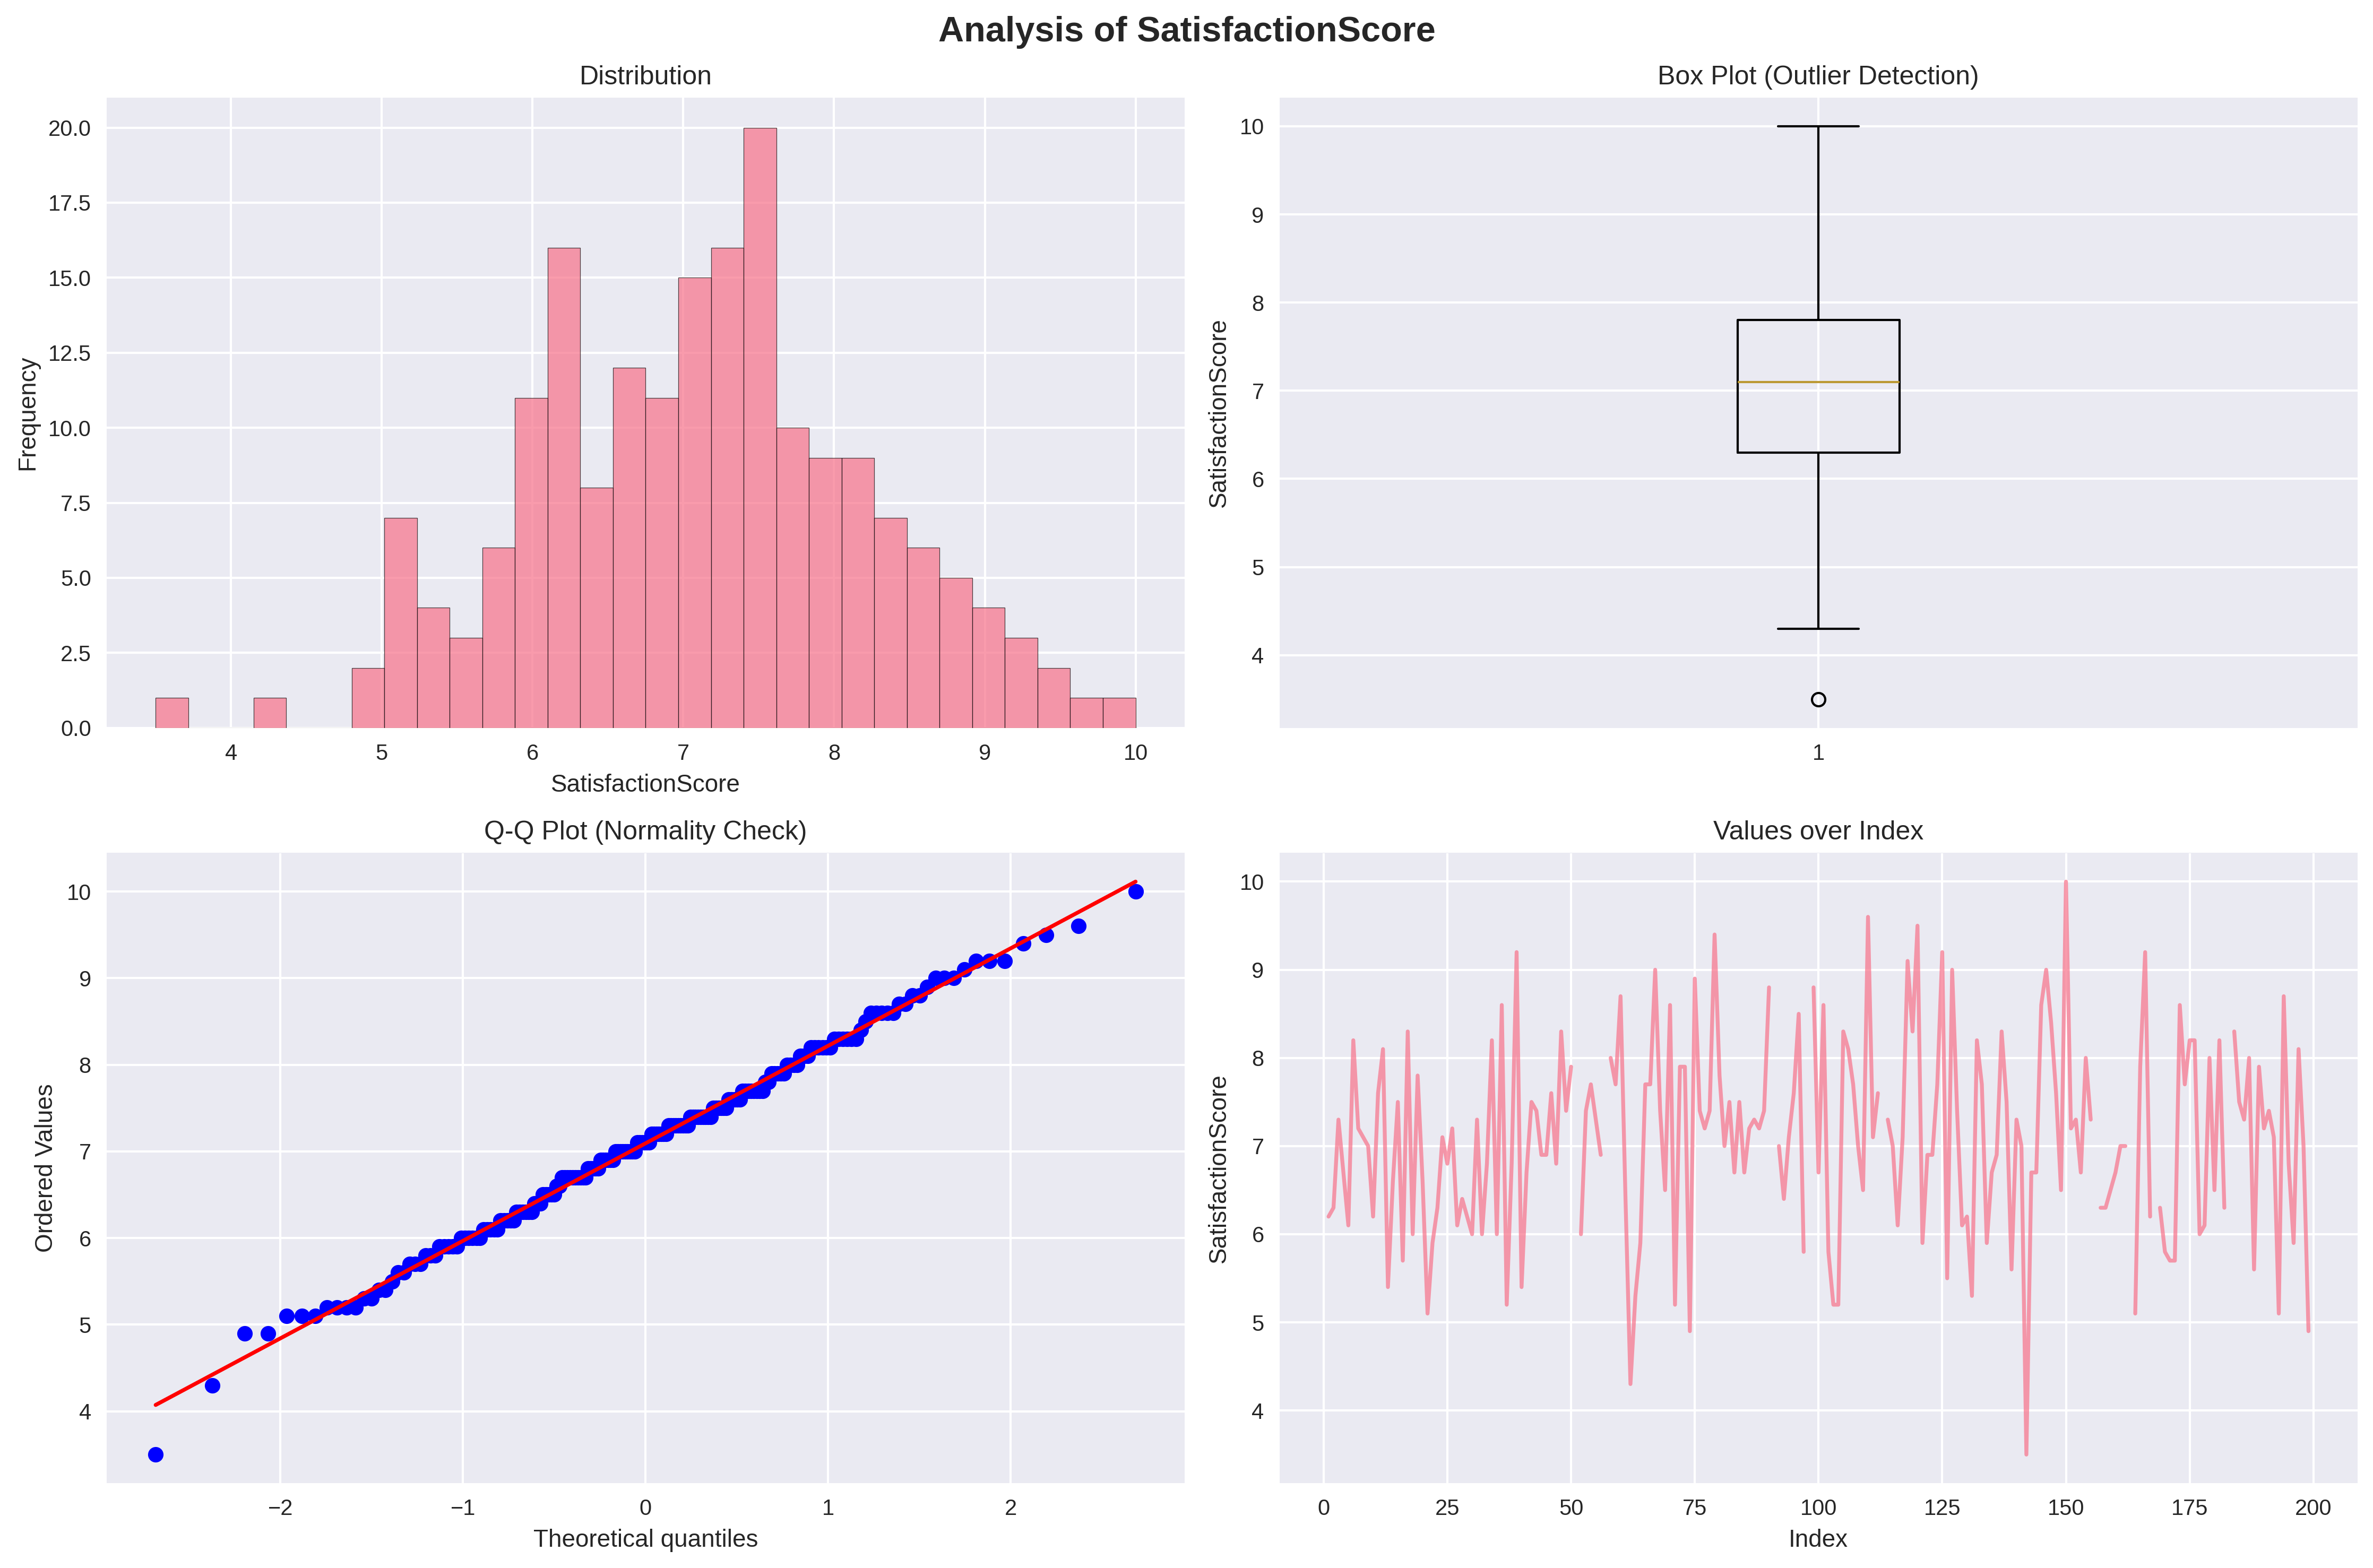


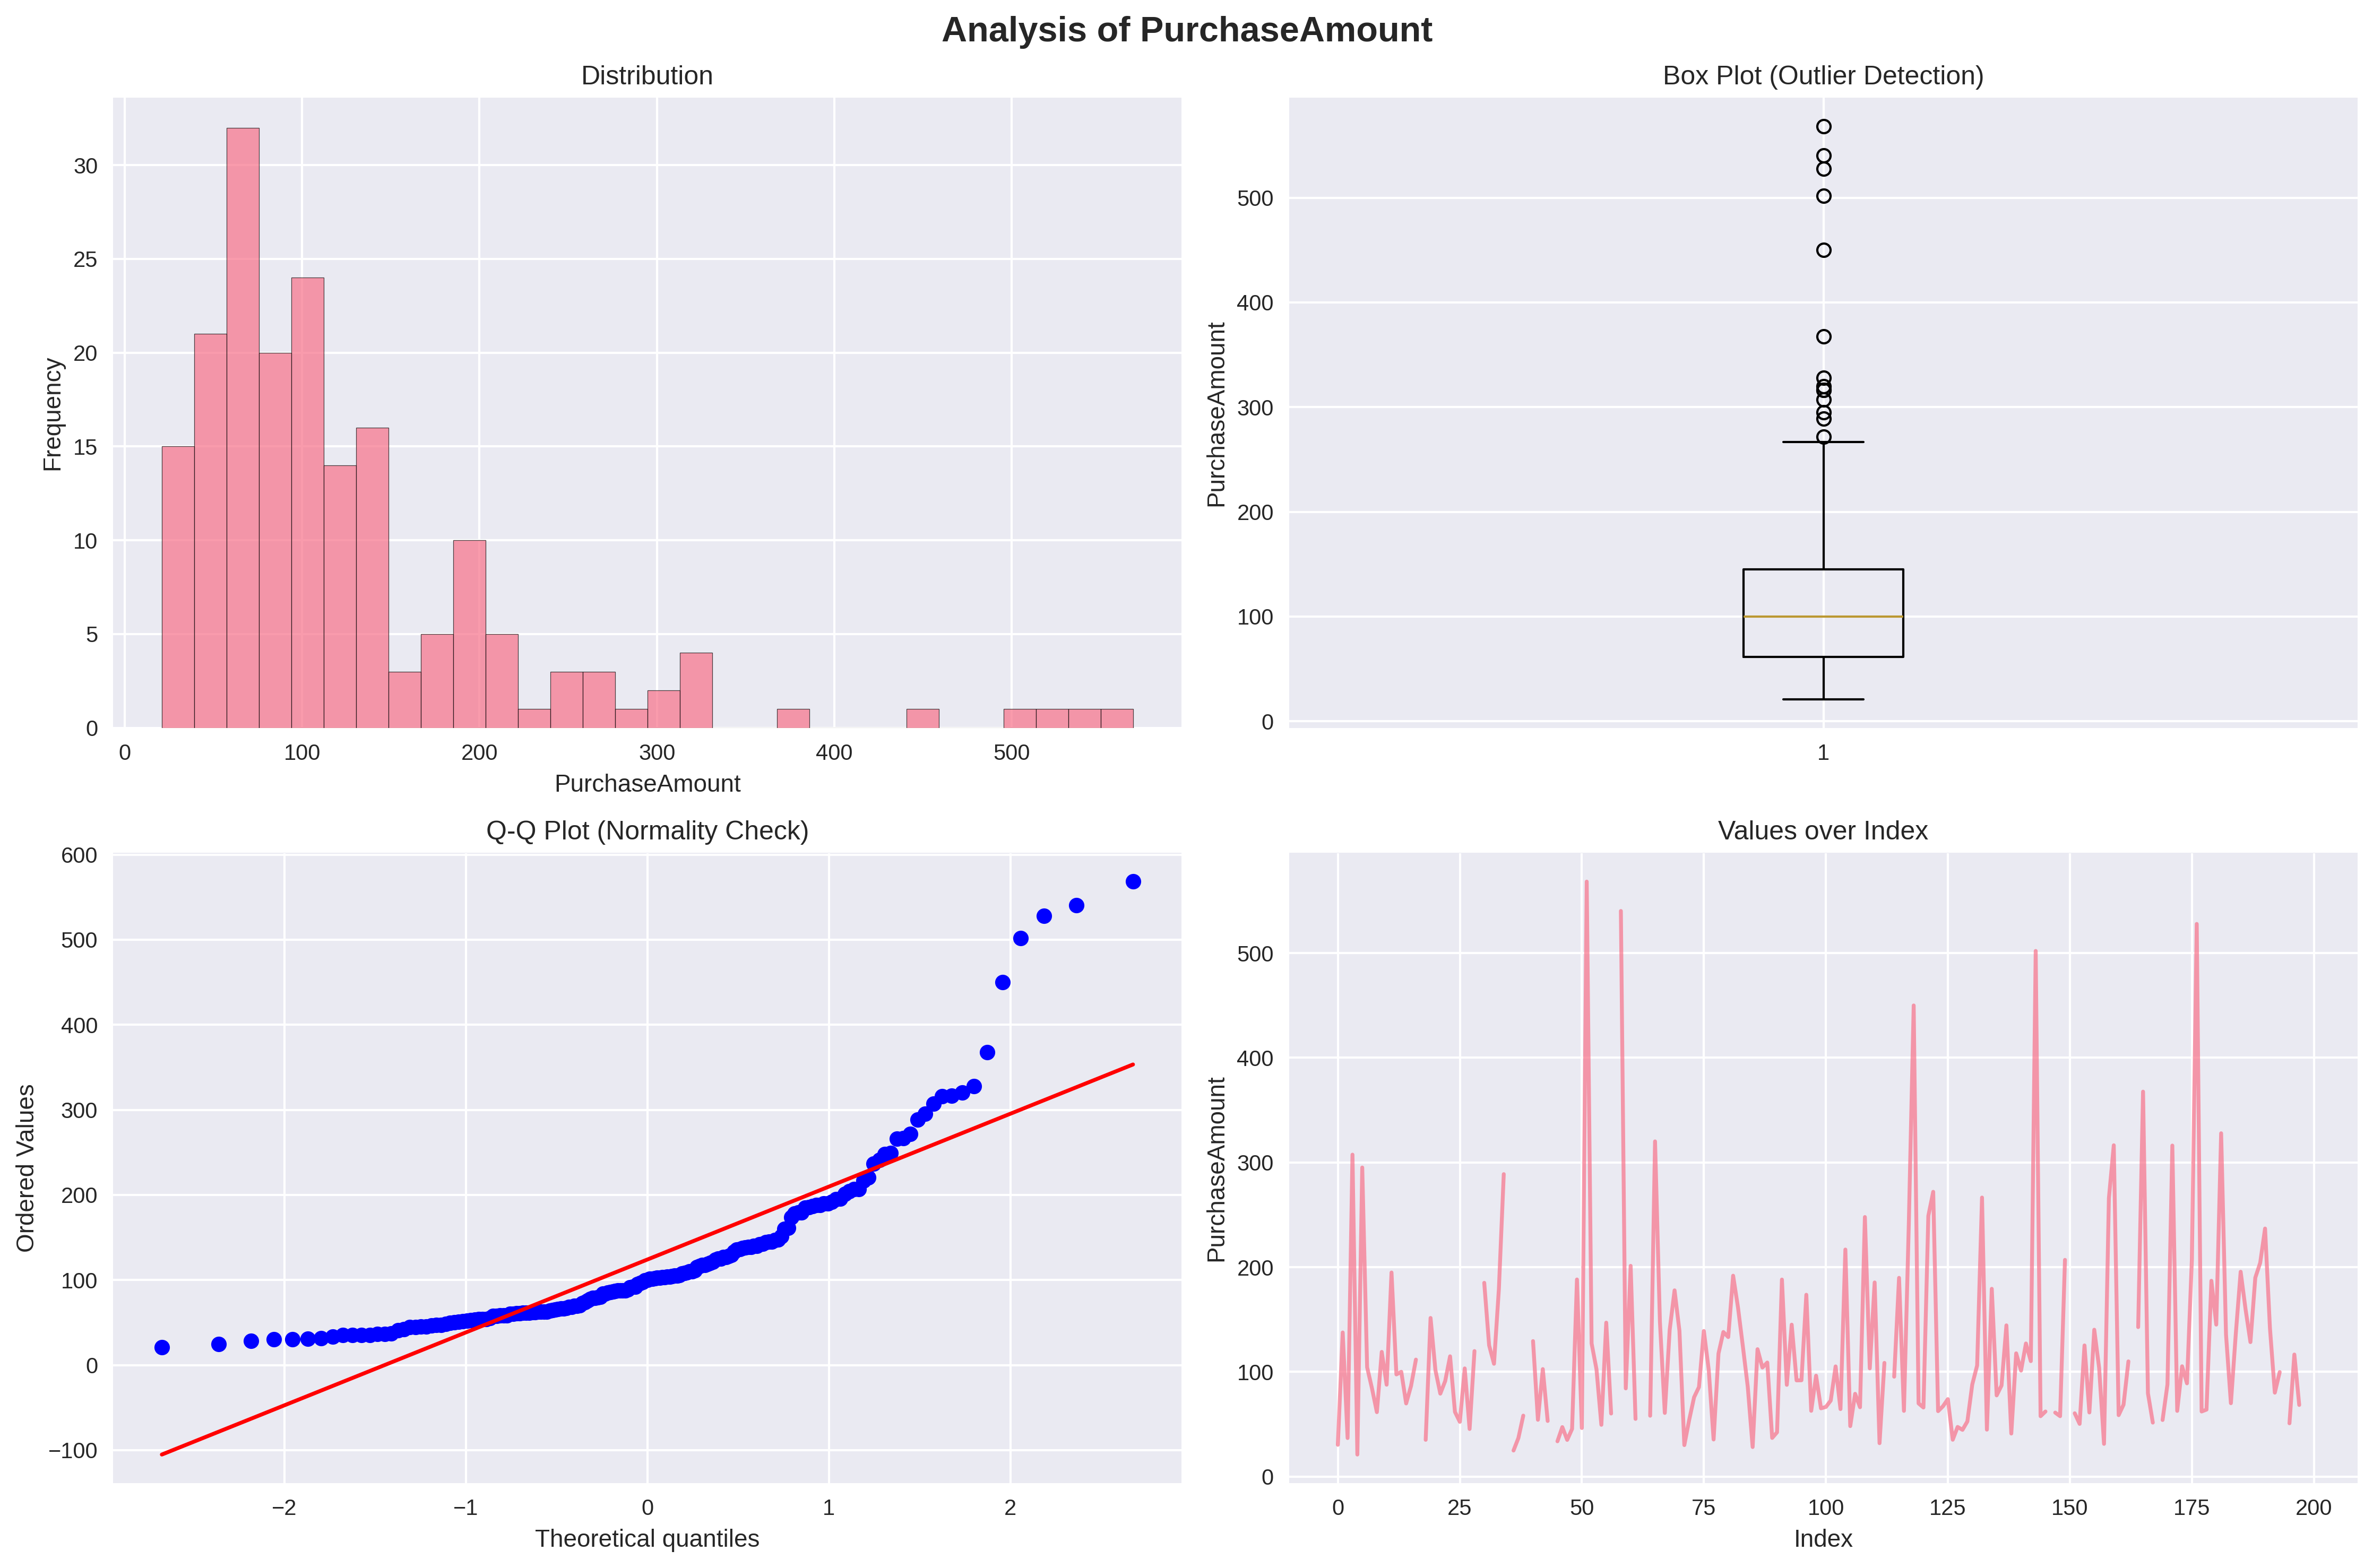


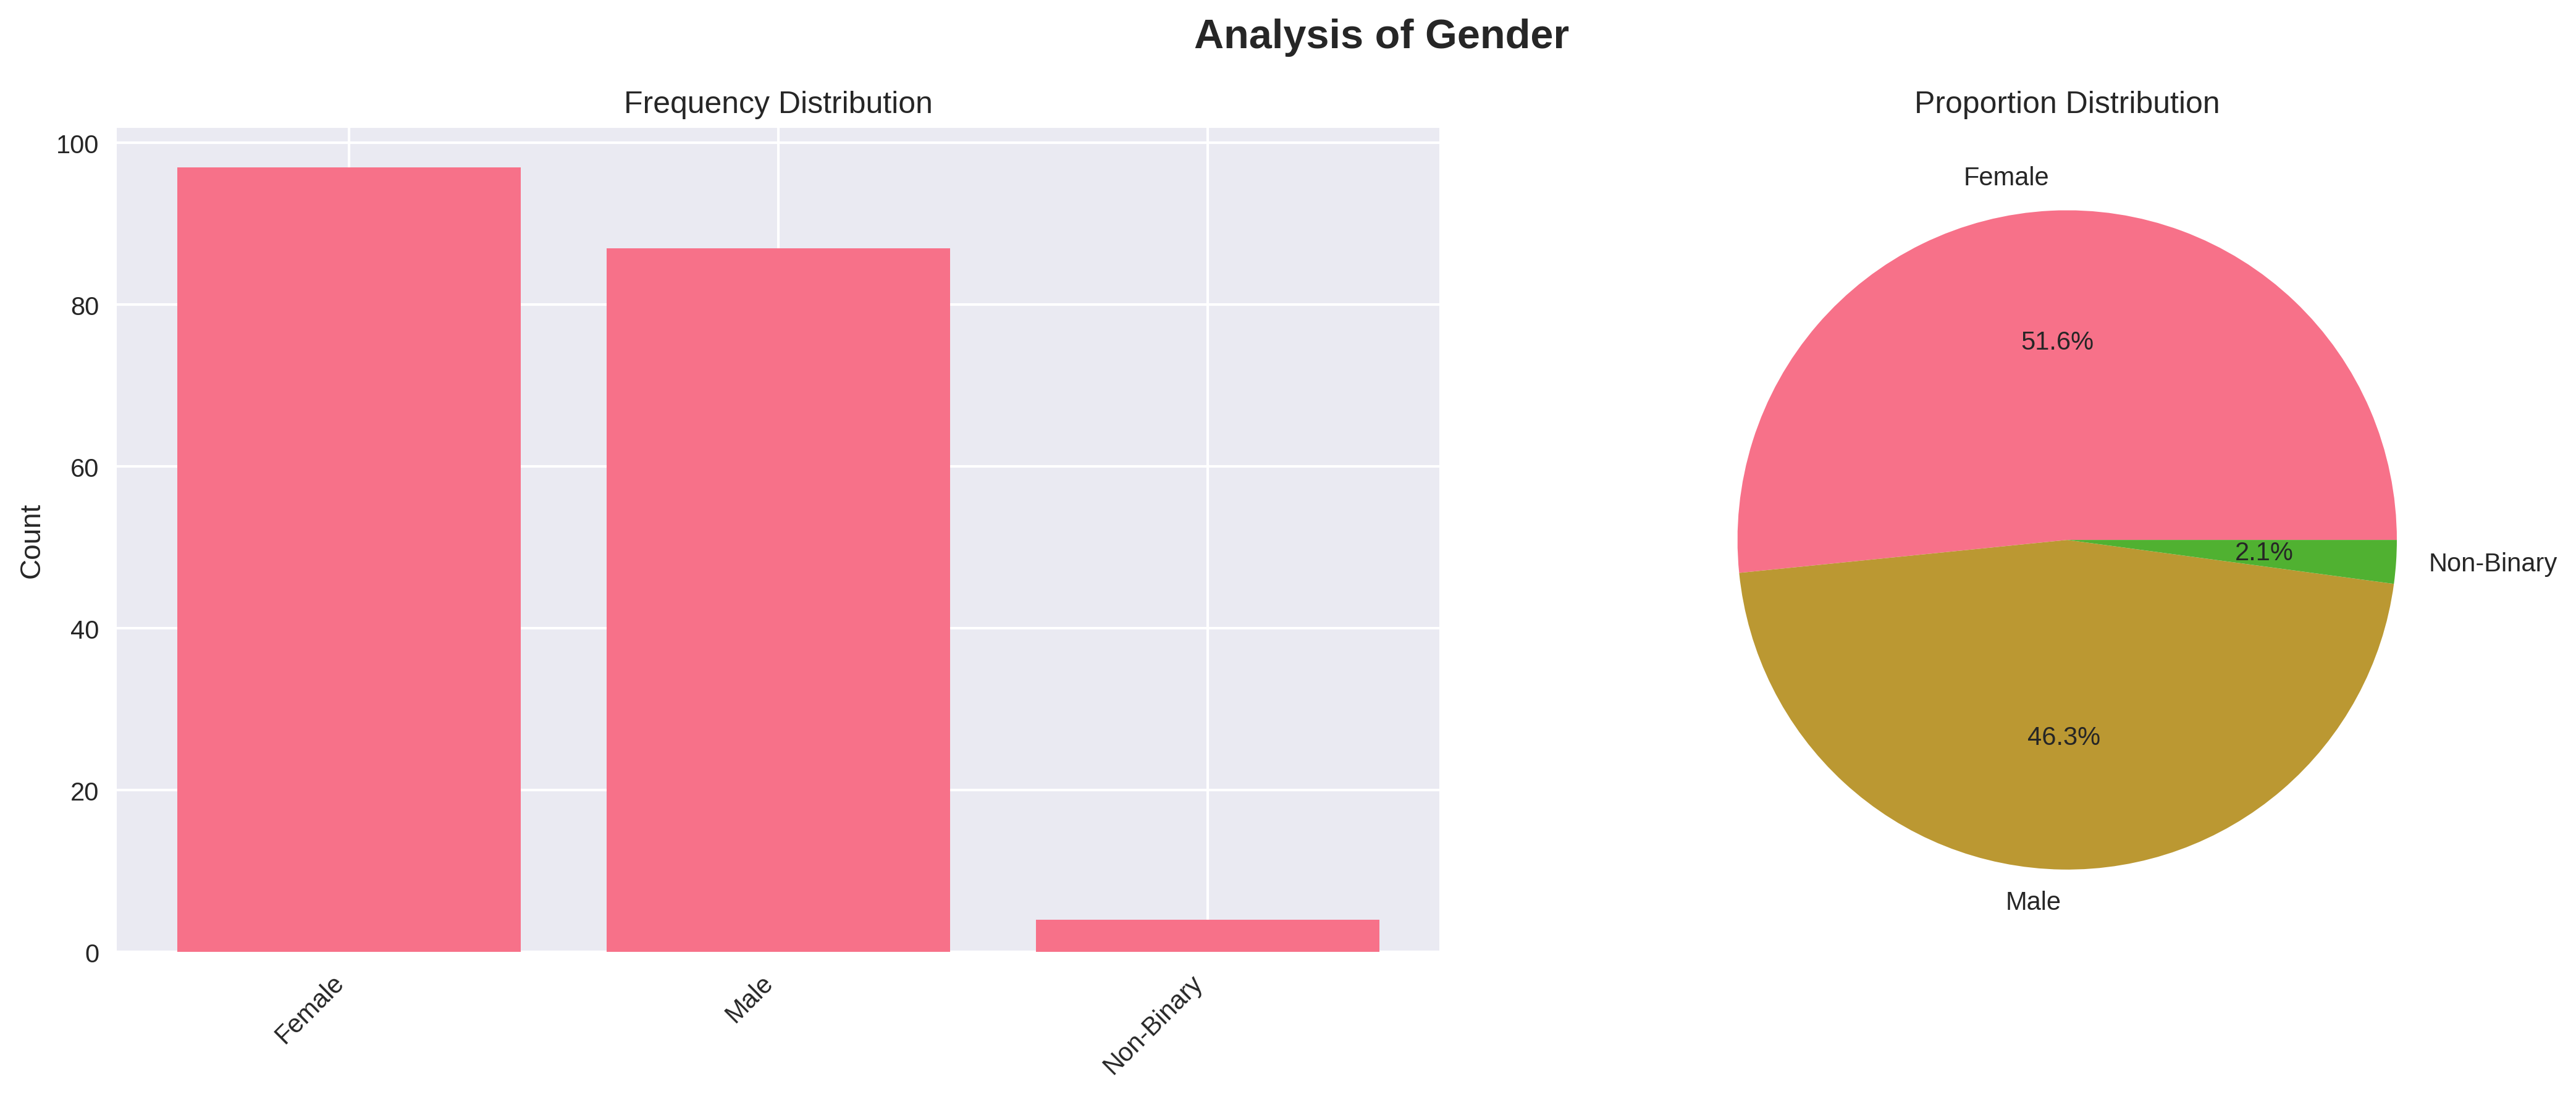


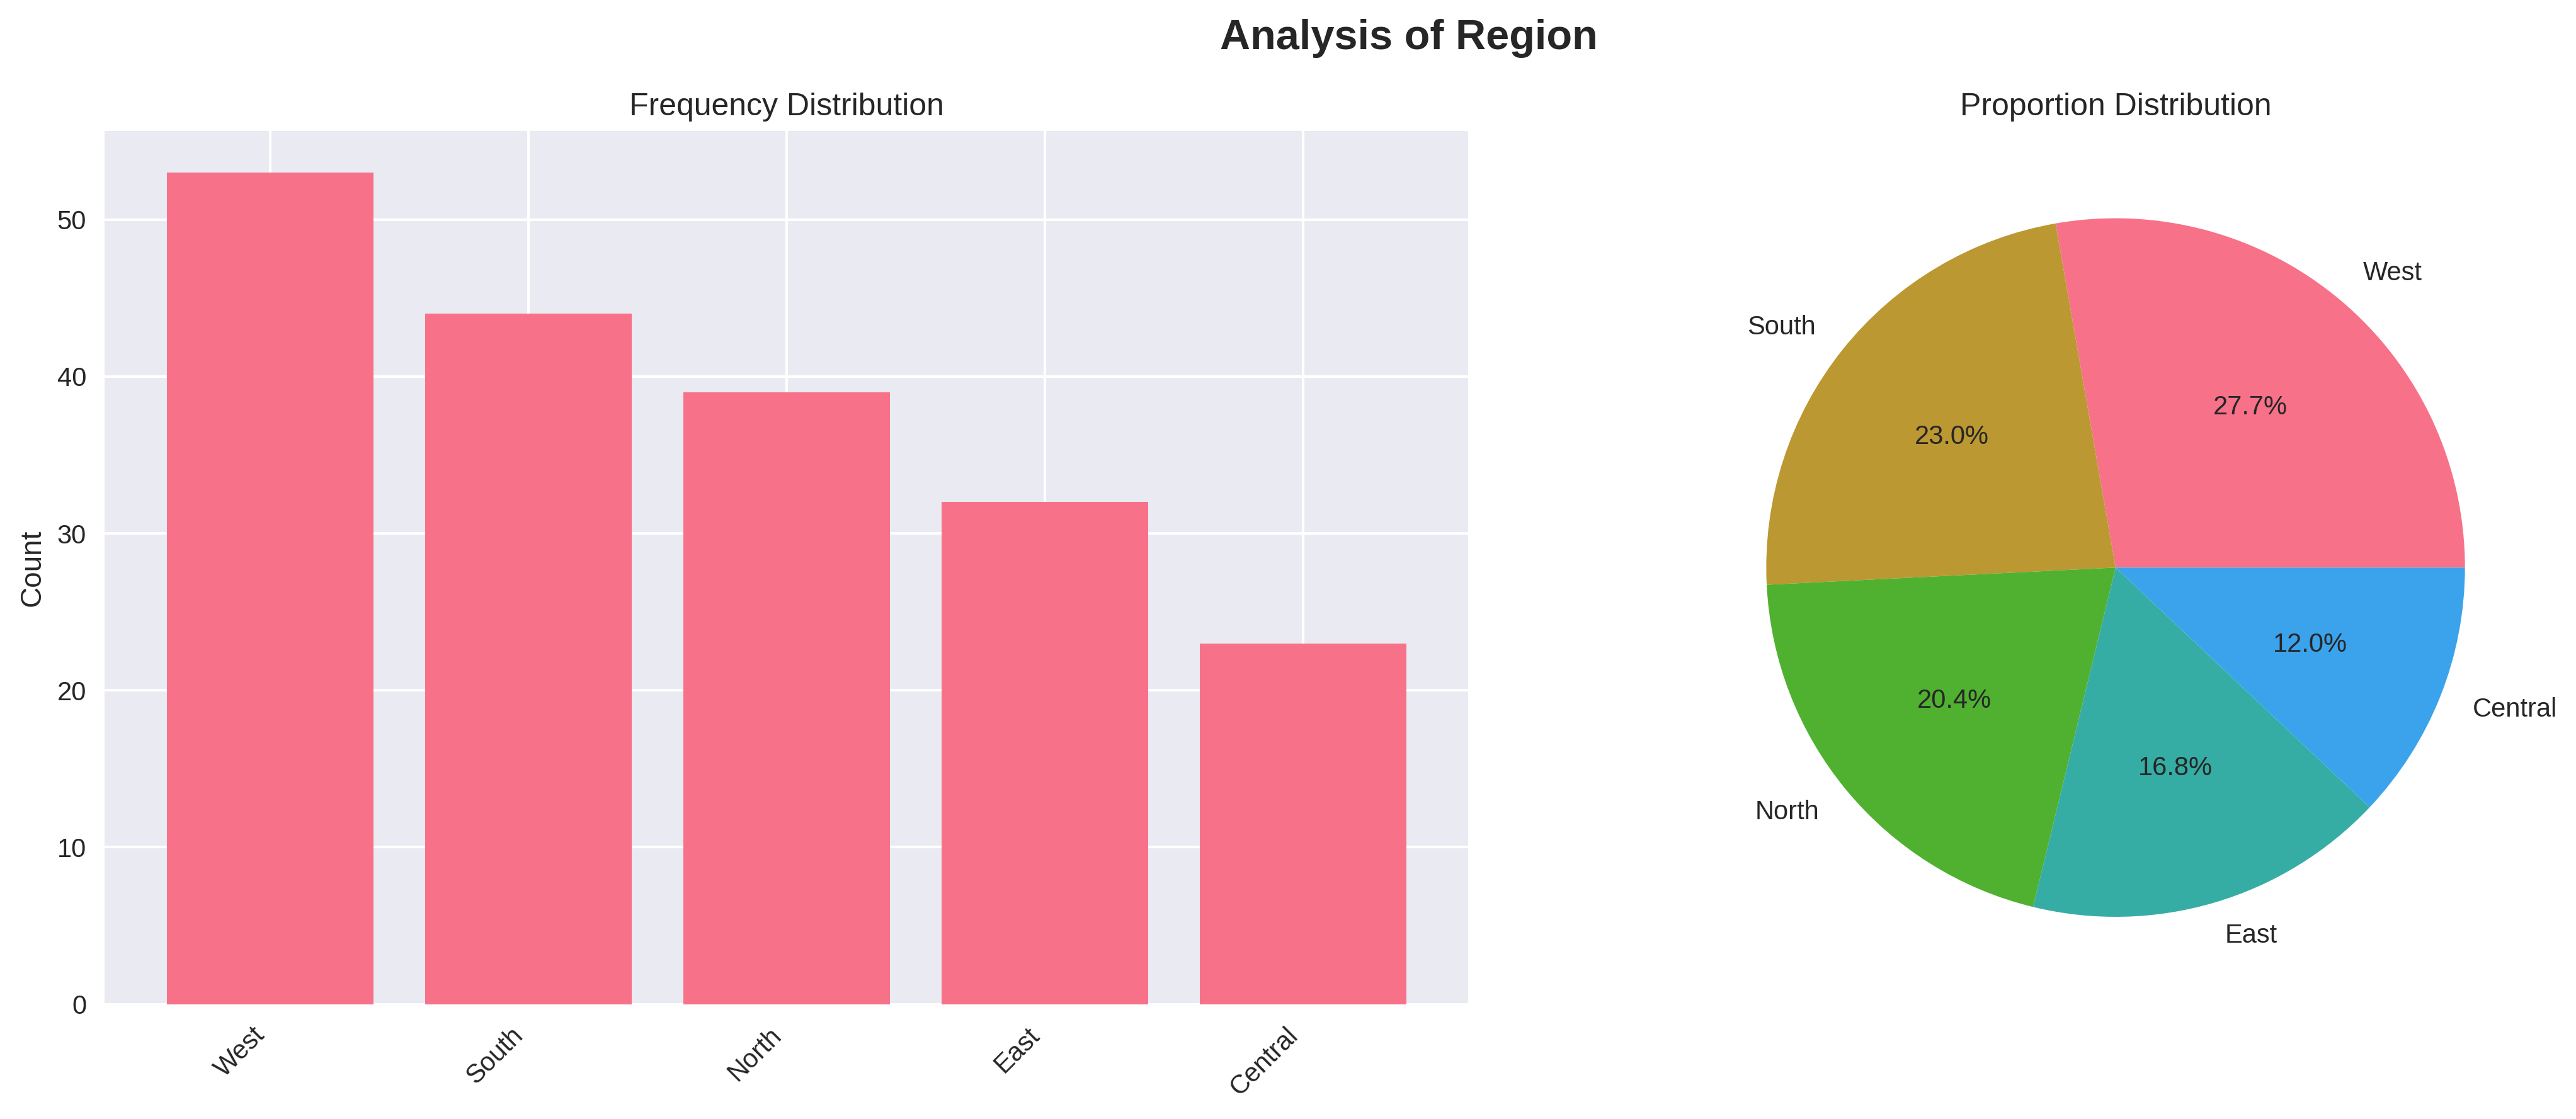


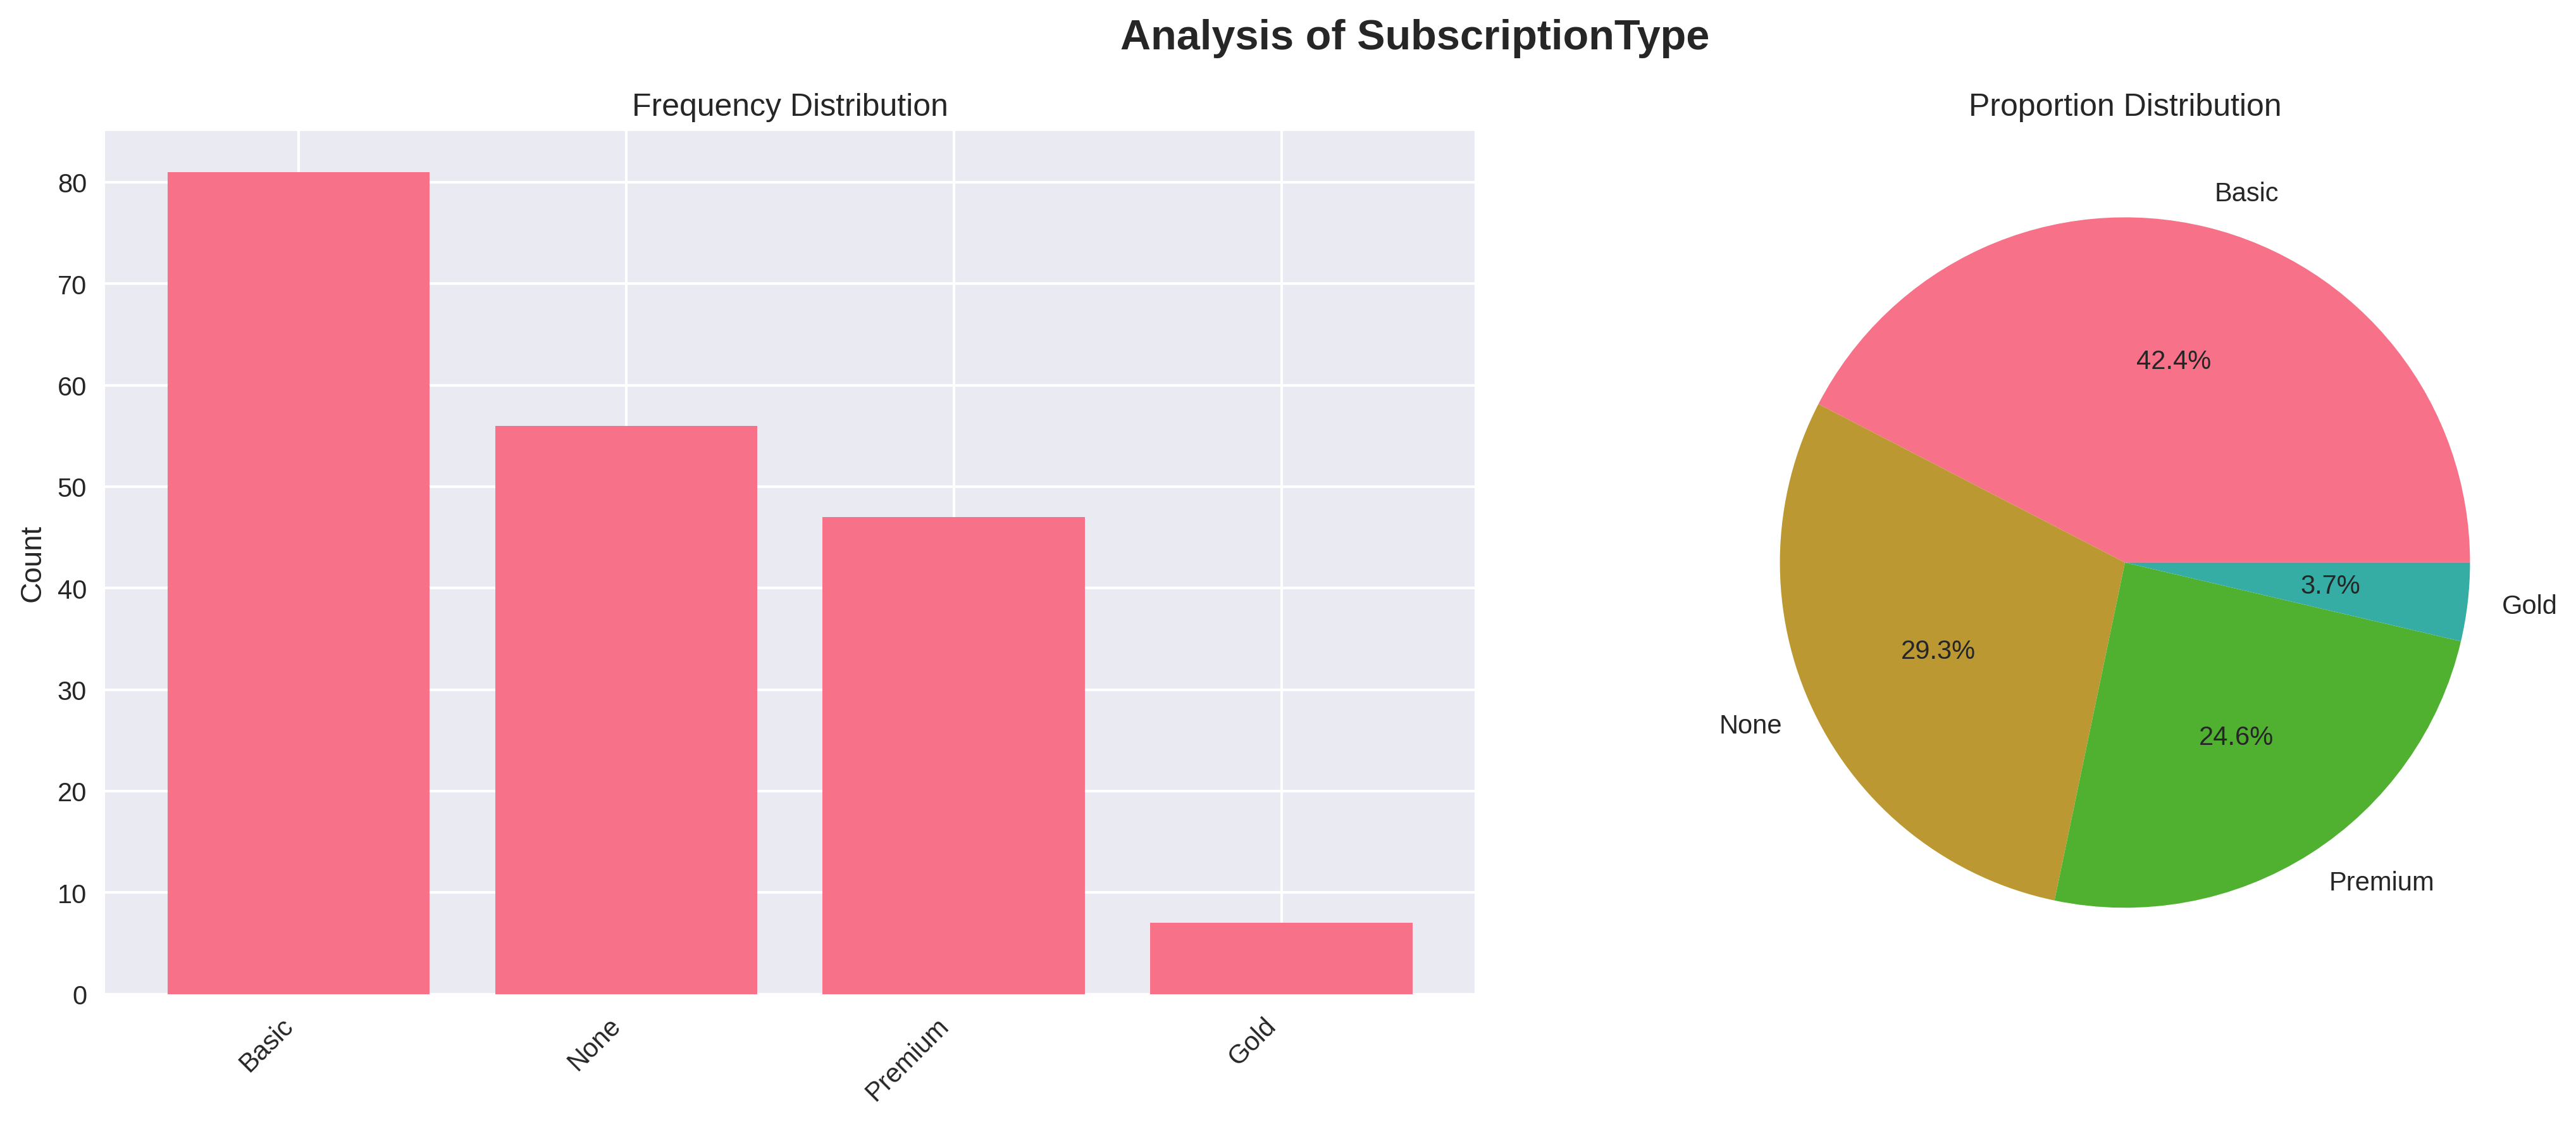


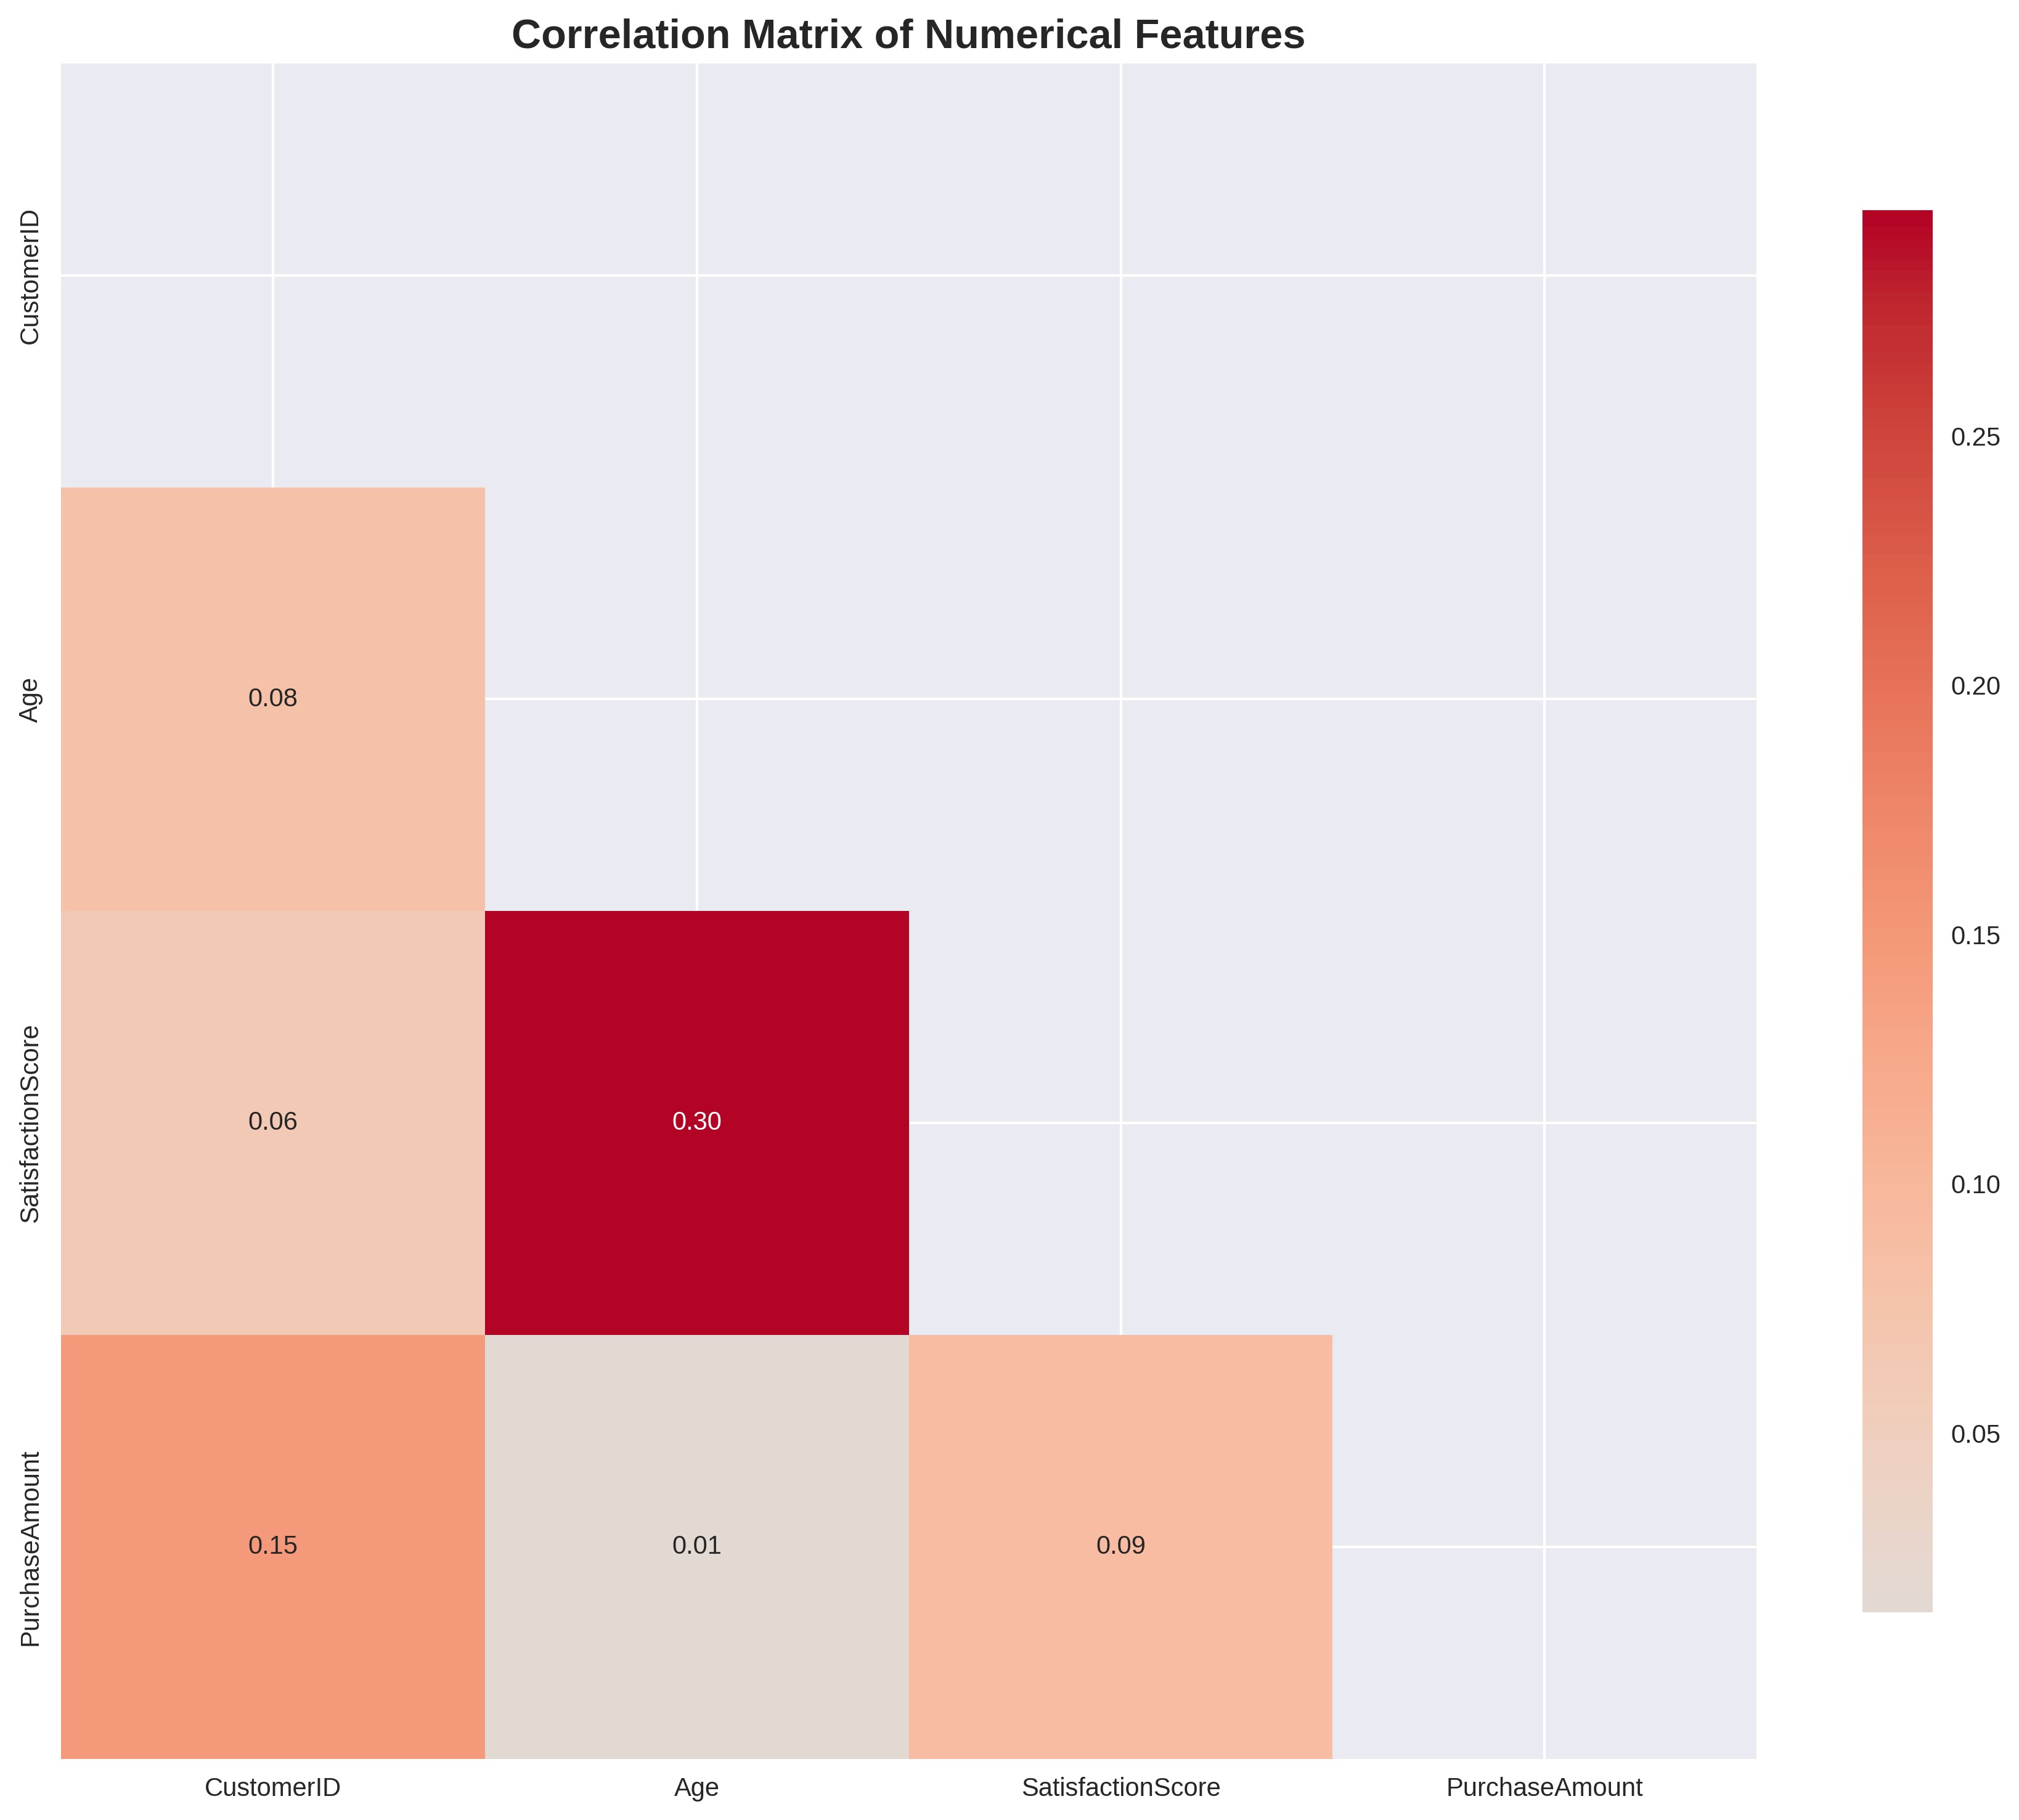


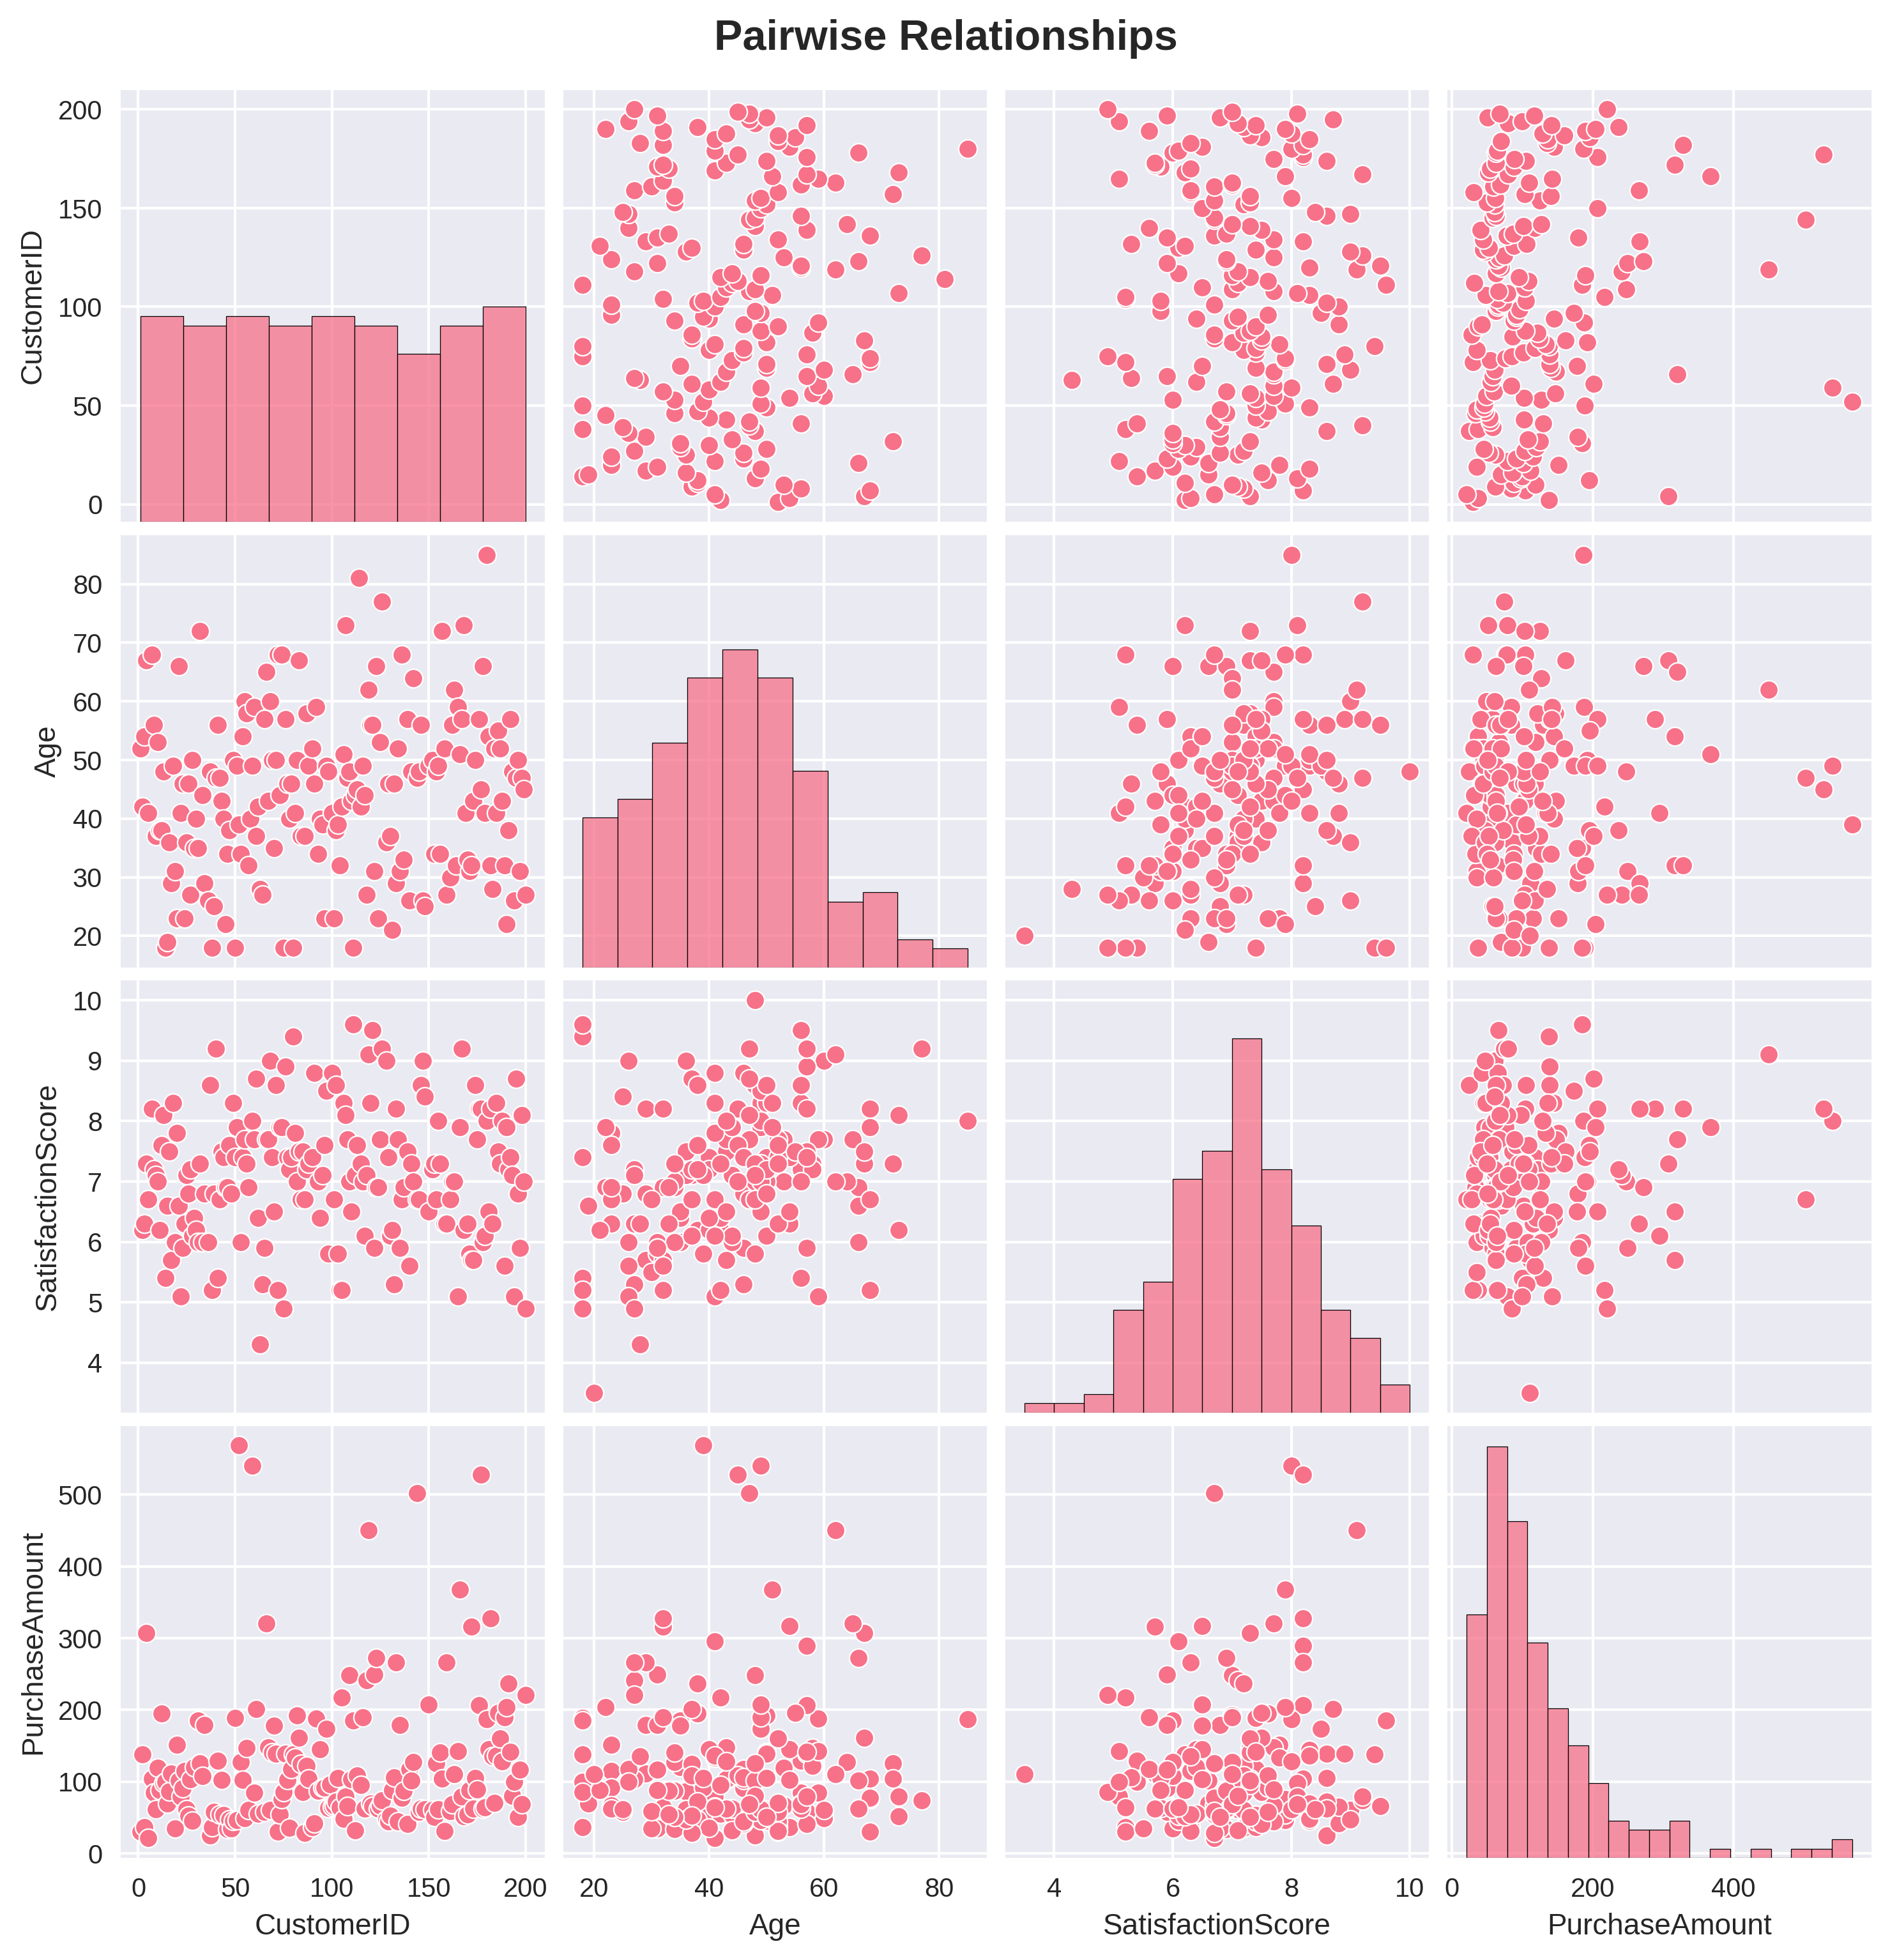


🔍 You can now ask questions about the data!
Type 'exit', 'quit', or 'bye' to end the session.

❓ Your question: what is the highest age?
⏳ Thinking...

🤖 Answer:
The highest value in 'Age' is 85.0.

❓ Your question: tell me the average purchase amount
⏳ Thinking...

🤖 Answer:
For 'Age':
- Mean (average): 43.9744
- Median: 44.0000

❓ Your question: what can you tell me about the subscription type
⏳ Thinking...

🤖 Answer:
## Step 1: Understand the Question
The user is asking for information about the "SubscriptionType" in the dataset. This requires analyzing the categorical data related to "SubscriptionType".


## Step 2: Review Available Information
From the provided dataset overview and column information, we know that "SubscriptionType" is an object (categorical) column with 4.5% missing values. The categorical analysis section tells us that "SubscriptionType" has 4 unique values and that the most frequent value is 'Basic'.


## Step 3: Analyze Categorical Data for SubscriptionType
S

In [25]:
if __name__ == "__main__":
    print("🤖 Initializing Data Analyst Agent...")
    agent = DataAnalystAgent()

    # Check if API key is set
    if agent.api_key == "your_api_key_here":
        api_key = input("⚠️ Please enter your Together.ai API key: ")
        agent.api_key = api_key

    # Run in interactive mode
    agent.interactive_mode()